# Libraries and imports:

In [ ]:
pip install pandas numpy nltk spacy

In [ ]:
!pip install gensim

In [ ]:
!pip install --upgrade tf-keras tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      S

In [ ]:
import os
import numpy  as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk

import re
import gensim   # For GloVe

import seaborn as sns
import matplotlib.pyplot as plt

import zipfile
import json
import ast  # For converting string representations of lists to actual lists
from collections import Counter

# RFE:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# RFECV:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

# Modeling:
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense

# Dense Layers:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Visualization:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing for LIWC:

In [ ]:
## Unzipping all files of the dataset and extracting them into a new file directory

zip_dir = '/content/drive/My Drive/DAIC-Woz/original'         # Directory containing zip files as provided by E-DAIC
extract_dir = '/content/drive/My Drive/DAIC-Woz/extracted'    # Directory of extracted files

# Iterate over all files in the zip directory
for filename in os.listdir(zip_dir):
    if filename.endswith('.zip'):
        file_path = os.path.join(zip_dir, filename)
        try:
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            print(f"Extracted: {filename}")
        except zipfile.BadZipFile:
            print(f"Failed to unzip: {filename}")
        except Exception as e:
            print(f"Error unzipping {filename}: {e}")

print("All files extracted.")

Extracted: 300_P.zip
Extracted: 301_P.zip
Extracted: 304_P.zip
Extracted: documents.zip
Extracted: util.zip
Extracted: 303_P.zip
Extracted: 302_P.zip
Extracted: 308_P.zip
Extracted: 306_P.zip
Extracted: 305_P.zip
Extracted: 309_P.zip
Extracted: 310_P.zip
Extracted: 311_P.zip
Extracted: 307_P.zip
Extracted: 313_P.zip
Extracted: 312_P.zip
Extracted: 317_P.zip
Extracted: 318_P.zip
Extracted: 314_P.zip
Extracted: 315_P.zip
Extracted: 316_P.zip
Extracted: 319_P.zip
Extracted: 321_P.zip
Extracted: 320_P.zip
Extracted: 326_P.zip
Extracted: 323_P.zip
Extracted: 324_P.zip
Extracted: 322_P.zip
Extracted: 325_P.zip
Extracted: 330_P.zip
Extracted: 331_P.zip
Extracted: 327_P.zip
Extracted: 329_P.zip
Extracted: 328_P.zip
Extracted: 333_P.zip
Extracted: 332_P.zip
Extracted: 334_P.zip
Extracted: 335_P.zip
Extracted: 336_P.zip
Extracted: 338_P.zip
Extracted: 339_P.zip
Extracted: 340_P.zip
Extracted: 341_P.zip
Extracted: 337_P.zip
Extracted: 347_P.zip
Extracted: 345_P.zip
Extracted: 343_P.zip
Extracted:

pre-LIWC analysis- processing:

In [ ]:
def preprocess_text(df):
'''Filters to keep only the participant's responses and concatenates them.'''

    # Keep only the rows where 'speaker' is 'Participant'
    participant = df[df['speaker'] == 'Participant']['value'].astype(str)
    # Concatenate all participant responses into a single string
    text = ' '.join(participant)

    return text

# Directories for the transcript files and the output cleaned text files
transcript_dir = '/content/drive/My Drive/DAIC-Woz/extracted'
cleaned_transcripts_dir = '/content/drive/My Drive/DAIC-Woz/cleaned-txt'

# Create the output directory if it doesn't exist
if not os.path.exists(cleaned_transcripts_dir):
    os.makedirs(cleaned_transcripts_dir)

# Process each transcript file
for filename in os.listdir(transcript_dir):
    if filename.endswith('_TRANSCRIPT.csv') and not filename.startswith('._'):
        transcript_file = os.path.join(transcript_dir, filename)
        cleaned_file = os.path.join(cleaned_transcripts_dir, filename.replace('_TRANSCRIPT.csv', '_CLEANED_TRANSCRIPT.txt'))

        try:
            # Load the transcript into a DataFrame
            df = pd.read_csv(transcript_file, sep='\t')
            # Apply preprocessing to filter and concatenate participant responses
            transcript_text = preprocess_text(df)
            # Write the processed text to a file
            with open(cleaned_file, 'w', encoding='utf-8') as file:
                file.write(transcript_text)
            print(f"Processed and written file: {cleaned_file}")  # Print statement for checking the progress
        except Exception as e:
            print(f"Error processing {transcript_file}: {e}")  # Print statement for identifying any errors

print("All transcripts processed.")

Processed and written file: /content/drive/My Drive/DAIC-Woz/cleaned-txt/300_CLEANED_TRANSCRIPT.txt
Processed and written file: /content/drive/My Drive/DAIC-Woz/cleaned-txt/301_CLEANED_TRANSCRIPT.txt
Processed and written file: /content/drive/My Drive/DAIC-Woz/cleaned-txt/304_CLEANED_TRANSCRIPT.txt
Processed and written file: /content/drive/My Drive/DAIC-Woz/cleaned-txt/303_CLEANED_TRANSCRIPT.txt
Processed and written file: /content/drive/My Drive/DAIC-Woz/cleaned-txt/302_CLEANED_TRANSCRIPT.txt
Processed and written file: /content/drive/My Drive/DAIC-Woz/cleaned-txt/308_CLEANED_TRANSCRIPT.txt
Processed and written file: /content/drive/My Drive/DAIC-Woz/cleaned-txt/306_CLEANED_TRANSCRIPT.txt
Processed and written file: /content/drive/My Drive/DAIC-Woz/cleaned-txt/305_CLEANED_TRANSCRIPT.txt
Processed and written file: /content/drive/My Drive/DAIC-Woz/cleaned-txt/309_CLEANED_TRANSCRIPT.txt
Processed and written file: /content/drive/My Drive/DAIC-Woz/cleaned-txt/310_CLEANED_TRANSCRIPT.txt


In [ ]:
## Finding the format of the transcripts

# Path to one of the transcript files
example_transcript = '/content/drive/My Drive/DAIC-Woz/extracted/301_TRANSCRIPT.csv'

# Load the file into a DataFrame and print the column names
example_df = pd.read_csv(example_transcript)
print(example_df.columns)

Index(['start_time\tstop_time\tspeaker\tvalue'], dtype='object')


In [ ]:
## Converting the results, from LIWC - Text analysis, from .txt to .csv
'''
- Each row corresponds to one participant's LIWC analysis results.
- Columns represent the different metrics and categories analyzed by LIWC.
'''

# Reading a tab-separated file
og-liwc_df = pd.read_csv('/content/drive/My Drive/DAIC-Woz/LIWC2015 Results (300_CLEANED_TRANSCRIPT - 492_CLEANED_TRANSCRIPT (189 files)).txt', sep='\t')

# Saving as CSV
og-liwc_df.to_csv('/content/drive/My Drive/DAIC-Woz/LIWC2015 Results (300_CLEANED_TRANSCRIPT - 492_CLEANED_TRANSCRIPT (189 files)).csv', index=False)

# LIWC analysis on specified categories and normalized data:

Extracting a csv of only the needed LIWC data:

In [ ]:
## Preparing a dataframe that contains only the data/categories relevant to our research question. This dataframe will be consequently used for
# for further analysis, such as normalization, statistical analysis or as input for our models.

# Load the LIWC results from a CSV file
liwc_data = pd.read_csv('/content/drive/My Drive/DAIC-Woz/LIWC2015 Results (300_CLEANED_TRANSCRIPT - 492_CLEANED_TRANSCRIPT (189 files)).csv')

# List of columns to keep
mapped_columns = [
    'Filename', 'WC', 'Tone', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad',
    'i', 'we', 'you', 'they', 'leisure', 'work', 'social', 'focuspast',
    'focusfuture', 'cogproc', 'bio', 'relativ', 'death', 'home', 'relig'
]

# Create a new DataFrame with only the selected columns
specified_columns_df = liwc_data[mapped_columns].copy()

# Display the first few rows of the new DataFrame for verification
print(specified_columns_df.head())

# Save the DataFrame to a CSV file
specified_columns_df.to_csv('/content/drive/My Drive/DAIC-Woz/specified-LIWC-data.csv', index=False)

                     Filename    WC   Tone  affect  posemo  negemo   anx  \
0  300_CLEANED_TRANSCRIPT.txt   352  99.00   11.08    9.66    1.42  0.28   
1  301_CLEANED_TRANSCRIPT.txt  1472  87.50    6.25    4.89    1.29  0.27   
2  302_CLEANED_TRANSCRIPT.txt   615  94.79    6.50    5.53    0.98  0.16   
3  303_CLEANED_TRANSCRIPT.txt  1967  87.07    5.80    4.63    1.07  0.10   
4  304_CLEANED_TRANSCRIPT.txt   987  88.95    6.28    4.86    1.11  0.00   

   anger   sad      i  ...  work  social  focuspast  focusfuture  cogproc  \
0   0.57  0.00  11.93  ...  4.55    6.82       5.97         1.42     9.66   
1   0.54  0.20  11.62  ...  2.31    6.11       2.85         1.15    20.58   
2   0.16  0.33   6.67  ...  1.95    9.76       4.72         0.98    12.85   
3   0.25  0.31   7.78  ...  2.90   14.74       2.90         1.88    17.39   
4   0.51  0.20   9.83  ...  1.93   11.75       4.05         0.91    15.30   

    bio  relativ  death  home  relig  
0  1.70    15.91   0.00  0.28    0.0  
1 

Normalizing the above data before clustering:

In [ ]:
## Z-score normalization, which standardizes the data to have a mean of 0 and a standard deviation of 1 for each feature.

# Initialize the StandardScaler
scaler = StandardScaler()

# We want to normalize only the numerical columns, so we have to exclude 'Filename', which is categorical
numerical_columns = specified_columns_df.columns.drop(['Filename'])

# Fit the scaler to the data (excluding non-numeric columns) and transform it
specified_columns_df[numerical_columns] = scaler.fit_transform(specified_columns_df[numerical_columns])

# Save the normalized DataFrame to a CSV file
specified_columns_df.to_csv('/content/drive/My Drive/DAIC-Woz/specified-LIWC-data-normalized.csv', index=False)

Clustering only the normalized specific categories from LIWC:

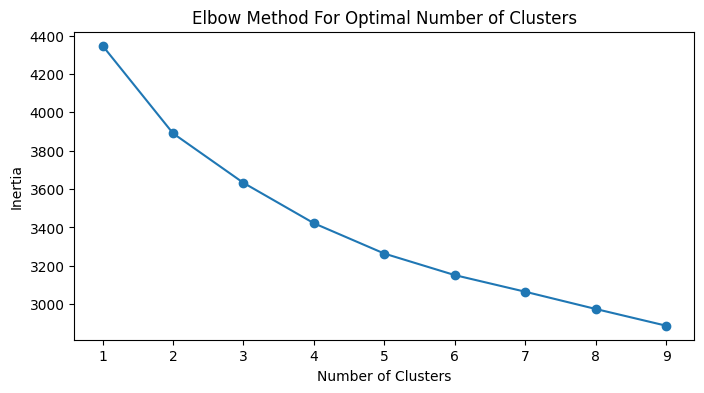

In [ ]:
# Load the normalized LIWC results from a CSV file
norm_liwc_data_specified = pd.read_csv('/content/drive/My Drive/DAIC-Woz/specified-LIWC-data-normalized.csv')

# Exclude non-numeric columns (e.g., 'Filename')
norm_liwc_numeric_specified = norm_liwc_data_specified.select_dtypes(include=[float, int])

# Replace NaN values with mean or median if needed
# liwc_numeric = liwc_numeric.fillna(liwc_numeric.mean())

inertia = []
for n in range(1, 10):
    kmeans = KMeans(n_clusters=n, n_init=10, random_state=42).fit(norm_liwc_numeric_specified)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, marker='o')  # Range should match the previously defined range on the above for loop
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

# In this case, the "elbow" is not sharply defined, which can happen with complex or high-dimensional data.

kmeans clustering (4 clusters) on the normalized data:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-7-d6058a0ed98c>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(norm_liwc_data.groupby('Cluster').mean())


               WC      Tone    affect    posemo    negemo       anx     anger  \
Cluster                                                                         
0       -0.725534  0.747834  0.323756  0.637419 -0.614958 -0.176737 -0.430114   
1       -0.023834 -1.194661  0.087344 -0.545376  1.329952  0.631173  0.749330   
2        0.936315 -0.474137 -0.967992 -0.817997 -0.426256 -0.308061 -0.209213   
3       -0.406943  0.681746  0.693652  0.706782  0.052884  0.048476  0.059523   

              sad         i        we  ...      work    social  focuspast  \
Cluster                                ...                                  
0       -0.409236 -0.161908  0.274676  ...  0.586203 -0.270788   0.104730   
1        0.925161  0.147525 -0.257607  ... -0.013420 -0.294314   0.345795   
2       -0.210361 -0.167728  0.341021  ... -0.054952  0.407913   0.227269   
3       -0.064489  0.197060 -0.387208  ... -0.364863 -0.032995  -0.524127   

         focusfuture   cogproc       bio   relativ

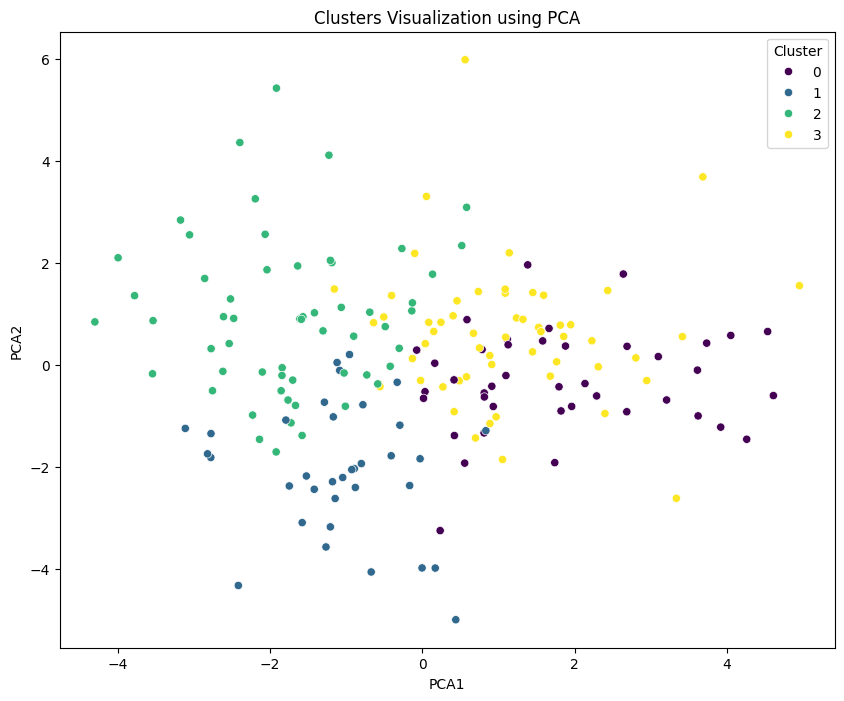

In [ ]:
# Assuming that 4 or 5 clusters is the best point based on the elbow method result, let's test on 4 clusters
n_clusters = 4

# Perform K-means clustering
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
norm_liwc_data_specified['Cluster'] = kmeans.fit_predict(norm_liwc_numeric_specified)

# Basic statistics for each cluster
print(norm_liwc_data_specified.groupby('Cluster').mean())

# Visualization: PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(norm_liwc_numeric_specified)
norm_liwc_data_specified['PCA1'] = principal_components[:, 0]
norm_liwc_data_specified['PCA2'] = principal_components[:, 1]

# Scatter plot of the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=norm_liwc_data_specified, palette='viridis')
plt.title('Clusters Visualization using PCA')
plt.show()

kmeans clustering (5 clusters) on the normalized data:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-13-d0adce453396>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(norm_liwc_data.groupby('Cluster').mean())


               WC      Tone    affect    posemo    negemo       anx     anger  \
Cluster                                                                         
0        1.085588 -0.481075 -0.752042 -0.684384 -0.218016 -0.159825 -0.110794   
1       -0.919781  0.948926  0.986293  1.272915 -0.477181 -0.154204 -0.495579   
2       -0.092683 -1.412696  0.070435 -0.636861  1.464486  0.739512  0.867858   
3        0.190922 -0.052503 -0.667049 -0.483542 -0.464961 -0.301365 -0.218671   
4       -0.395852  0.685954  0.555054  0.584409  0.007307  0.051040  0.064152   

              sad         i        we  ...      work    social  focuspast  \
Cluster                                ...                                  
0       -0.131054 -0.227221 -0.023363  ... -0.462101  0.660553  -0.345169   
1       -0.311325 -0.402042 -0.057996  ...  0.591627  0.108050  -0.275317   
2        1.020028  0.162884 -0.300980  ...  0.020115 -0.475343   0.378386   
3       -0.225429 -0.124385  0.614603  ...  0.2

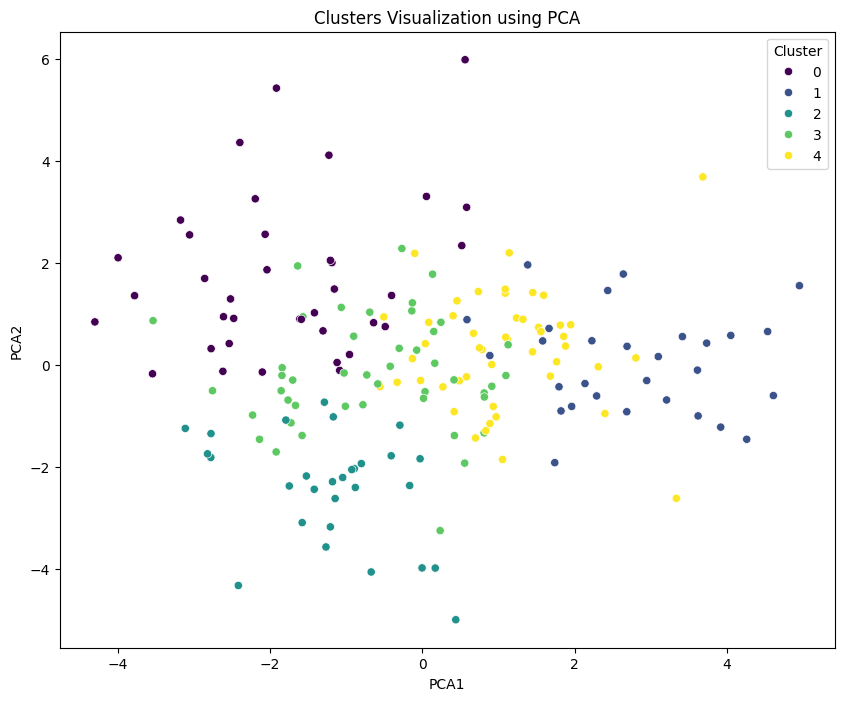

In [ ]:
# Under the same assumption, let's also test for 5 clusters
n_clusters = 5

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
norm_liwc_data_specified['Cluster'] = kmeans.fit_predict(norm_liwc_numeric_specified)

# Basic statistics for each cluster
print(norm_liwc_data_specified.groupby('Cluster').mean())

# Visualization: PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(norm_liwc_numeric_specified)
norm_liwc_data_specified['PCA1'] = principal_components[:, 0]
norm_liwc_data_specified['PCA2'] = principal_components[:, 1]

# Scatter plot of the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=norm_liwc_data_specified, palette='viridis')
plt.title('Clusters Visualization using PCA')
plt.show()

# Save the DataFrame with cluster labels to a new CSV file
norm_liwc_data_specified.to_csv('/content/drive/My Drive/DAIC-Woz/specified-liwc-data-normalized-and-clustered.csv', index=False)

Performing the silhouette scores method to clarify if 4 or 5 clusters are the most optimal for my data:

In [ ]:
# Initialize lists to store results
silhouette_scores = []

# Loop over 4 and 5 clusters
for n_clusters in [4, 5]:
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(norm_liwc_numeric_specified)

    # Calculate silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(norm_liwc_numeric_specified, cluster_labels)

    # Append the score to the list
    silhouette_scores.append((n_clusters, silhouette_avg))

    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

# Determine the number of clusters with the highest silhouette score
best_cluster_count, best_score = max(silhouette_scores, key=lambda x: x[1])
print(f"The best number of clusters based on silhouette score is {best_cluster_count} with a score of {best_score}.")

For n_clusters = 4, the average silhouette_score is : 0.08224449474467932
For n_clusters = 5, the average silhouette_score is : 0.07227588390506506
The best number of clusters based on silhouette score is 4 with a score of 0.08224449474467932.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Visualizations and Analysis on 4 clusters and on normalized specified liwc data:

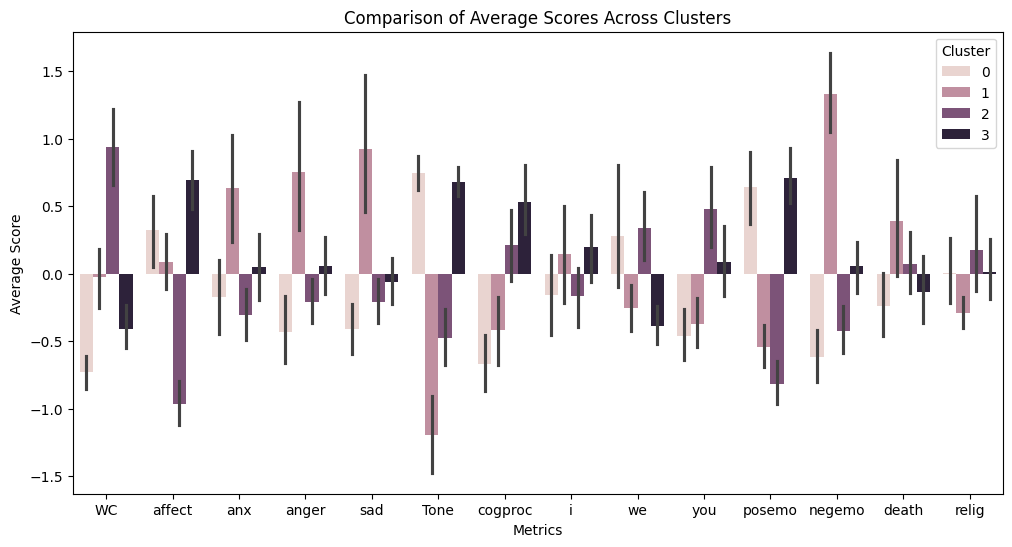

In [ ]:
# Comparing avg scores across clusters:

# Select metrics for comparison
metrics_of_interest = ['WC', 'affect', 'anx', 'anger', 'sad', 'Tone', 'cogproc', 'i', 'we', 'you', 'affect', 'posemo', 'negemo', 'death', 'relig']

# Melt the DataFrame for easier plotting
df_melted = norm_liwc_data_specified.melt(id_vars='Cluster', value_vars=metrics_of_interest)

# Create a bar plot for comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='variable', y='value', hue='Cluster', data=df_melted)
plt.title('Comparison of Average Scores Across Clusters')
plt.ylabel('Average Score')
plt.xlabel('Metrics')
plt.show()

In [ ]:
print(norm_liwc_data_specified.keys())

Index(['Filename', 'WC', 'Tone', 'affect', 'posemo', 'negemo', 'anx', 'anger',
       'sad', 'i', 'we', 'you', 'they', 'leisure', 'work', 'social',
       'focuspast', 'focusfuture', 'cogproc', 'bio', 'relativ', 'death',
       'home', 'relig', 'Cluster', 'PCA1', 'PCA2'],
      dtype='object')


In [ ]:
## Merging cleaned texts (used for LIWC analysis) with the normalized-clustered LIWC data:

text_files_dir = '/content/drive/My Drive/DAIC-Woz/cleaned-txt'

# Initialize an empty DataFrame
text_df = pd.DataFrame(columns=['Filename', 'CleanedText'])

# Loop through each file in the directory
for filename in os.listdir(text_files_dir):
    if filename.endswith('.txt'):
        file_path = os.path.join(text_files_dir, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text_content = file.read()
            # Create a DataFrame for the current file
            current_df = pd.DataFrame({'Filename': [filename], 'CleanedText': [text_content]})
            # Concatenate with the main DataFrame
            text_df = pd.concat([text_df, current_df], ignore_index=True)


# Merge the DataFrames on the 'Filename' column
merged_dfs = pd.merge(norm_liwc_data_specified, text_df, on='Filename', how='left')

# Save the merged DataFrame to a new CSV file
merged_dfs.to_csv('/content/drive/My Drive/DAIC-Woz/specified-liwc-data-normalized-and-clustered_merged-with-text.csv', index=False)

In [ ]:
## Qualitative analysis on the merged data:

# Iterate over each cluster
for cluster in sorted(merged_dfs['Cluster'].unique()):
    print(f"Cluster {cluster} Samples:")
    # Sample 3 texts from each cluster (Example)
    samples = merged_dfs[merged_dfs['Cluster'] == cluster]['CleanedText'].sample(3, random_state=42)
    # Print the sample texts
    for i, sample in enumerate(samples, 1):       # enumerate(iterable, start)
        print(f"Sample {i}:\n{sample}\n")
    print('-' * 50)

Cluster 0 Samples:
Sample 1:
<sync> yes i am i'm doing great i am originally from venezuela i was two years old yes i was um been only once i do not have family there anymore uh my uh siblings live in florida nowadays wow there's so many things i like about l_a i like the weather i like people overall i think the weather we're very lucky here traffic uh i have traveled some meeting new people and doing new learning about new cultures i enjoy languages uh traveling itself i have traveled to italy uh i lived there for seven and a half years and i studied abroad i've uh visit a few countries through europe and i had a real good time um probably traveling uh through rail along europe and getting to know cities in that way totally outgoing i do meditation um it's usually a practice that you can becomes very natural so my body's able to um sense when i'm not feeling at ease and i naturally um breathe and start my meditation process mm it could be hard if you don't practice it every day or if

                 WC        affect           anx         anger           sad  \
count  1.890000e+02  1.890000e+02  1.890000e+02  1.890000e+02  1.890000e+02   
mean   1.174839e-18  3.759485e-17  9.398713e-18 -4.605370e-16 -1.586033e-16   
std    1.002656e+00  1.002656e+00  1.002656e+00  1.002656e+00  1.002656e+00   
min   -1.614989e+00 -2.346402e+00 -1.567873e+00 -1.505531e+00 -1.197029e+00   
25%   -7.175142e-01 -5.899611e-01 -7.374551e-01 -6.141382e-01 -6.086588e-01   
50%   -2.218015e-01 -9.439378e-02 -1.255686e-01 -1.684416e-01 -1.825976e-01   
75%    4.717018e-01  6.144557e-01  5.737303e-01  4.364323e-01  4.057725e-01   
max    3.883590e+00  2.904102e+00  5.381410e+00  4.670550e+00  5.944568e+00   

               Tone       cogproc             i            we           you  \
count  1.890000e+02  1.890000e+02  1.890000e+02  1.890000e+02  1.890000e+02   
mean   5.639228e-17 -7.401487e-16  1.456801e-16 -7.284003e-17 -3.383537e-16   
std    1.002656e+00  1.002656e+00  1.002656e+00  1.

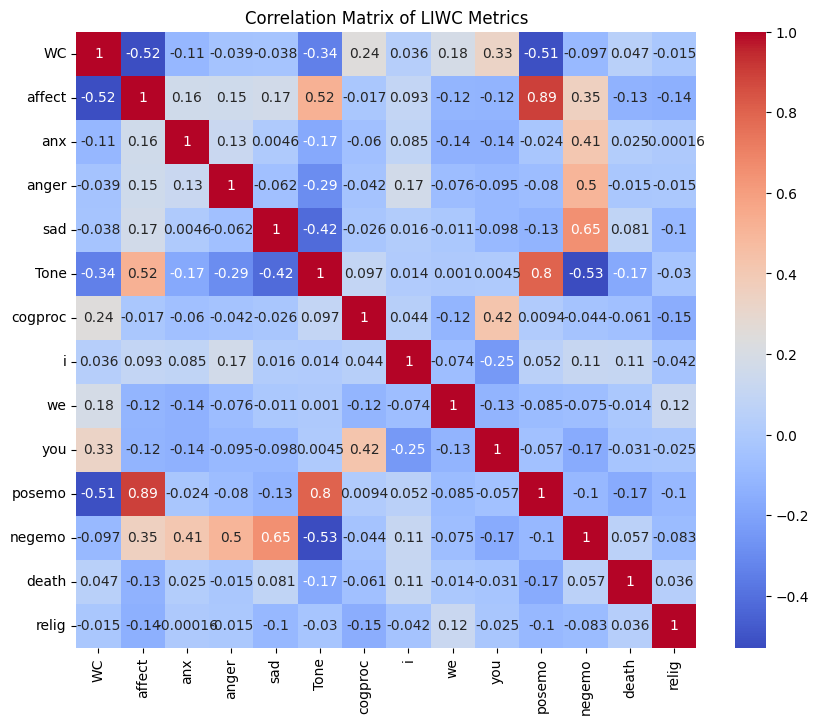

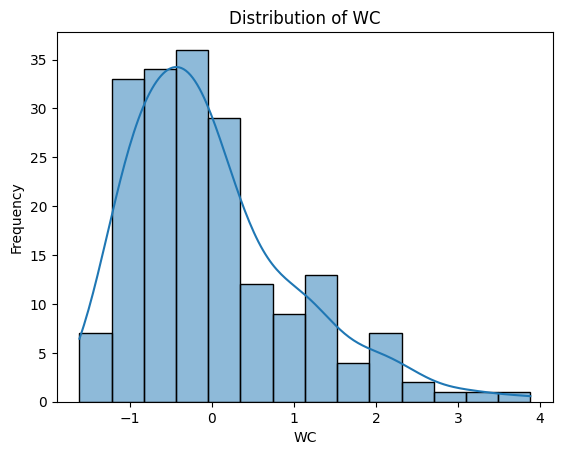

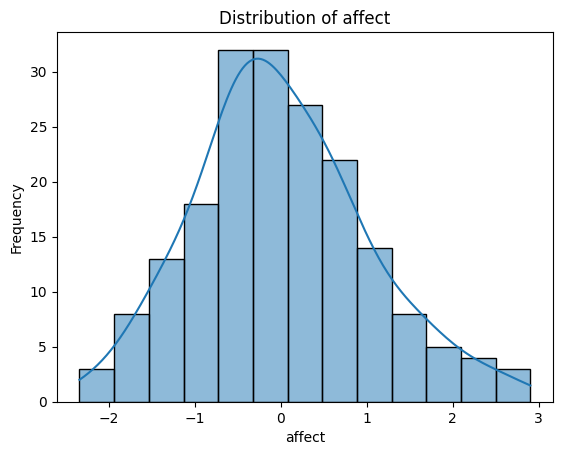

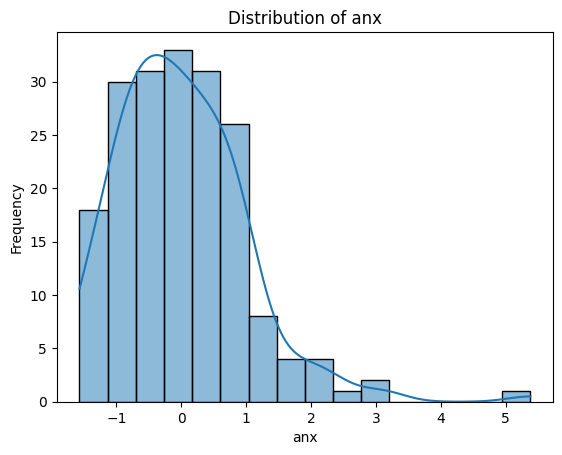

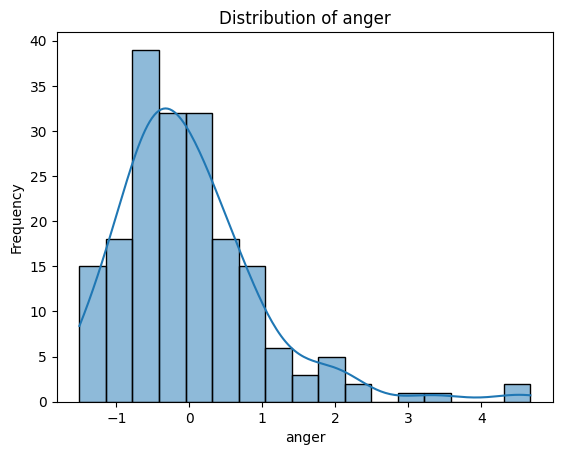

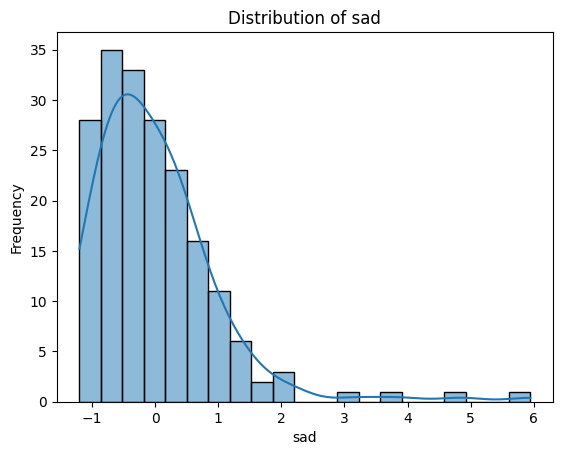

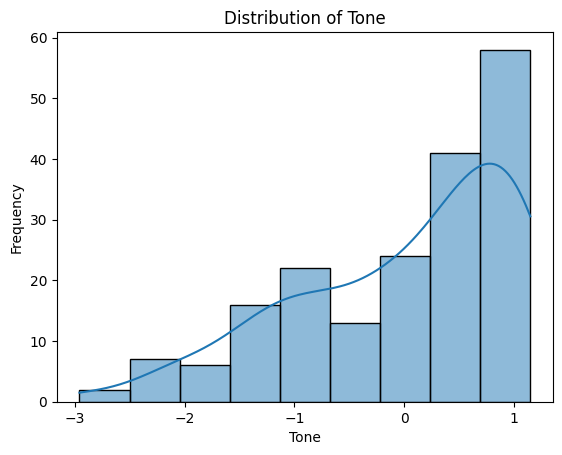

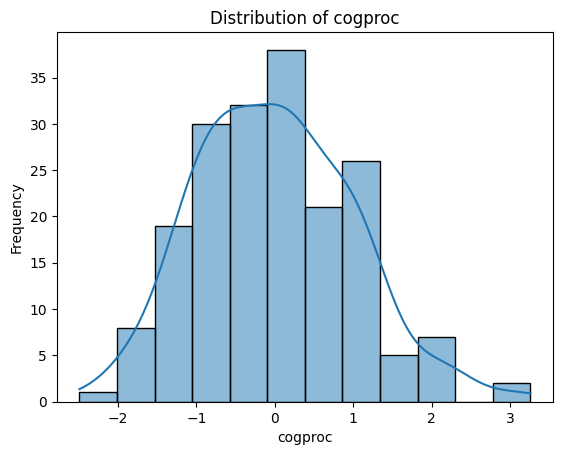

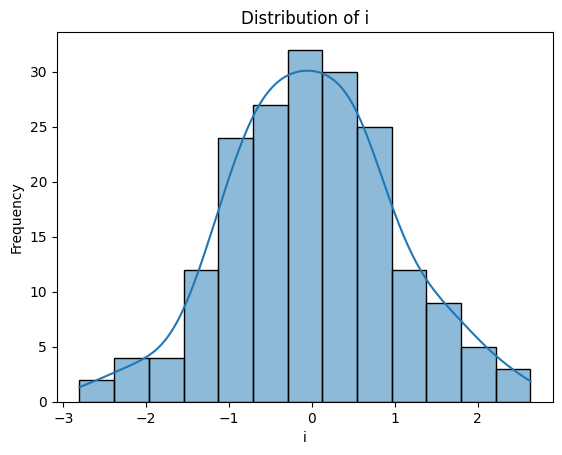

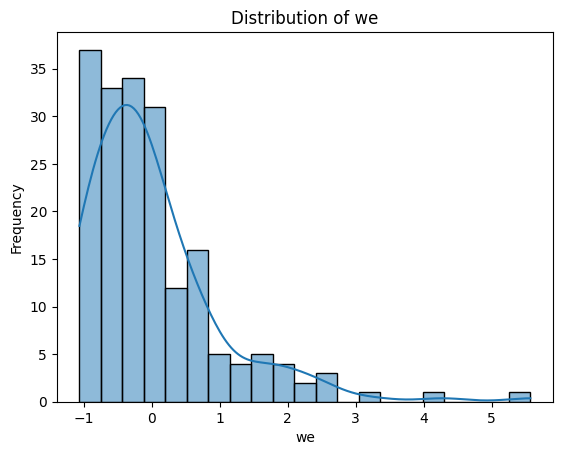

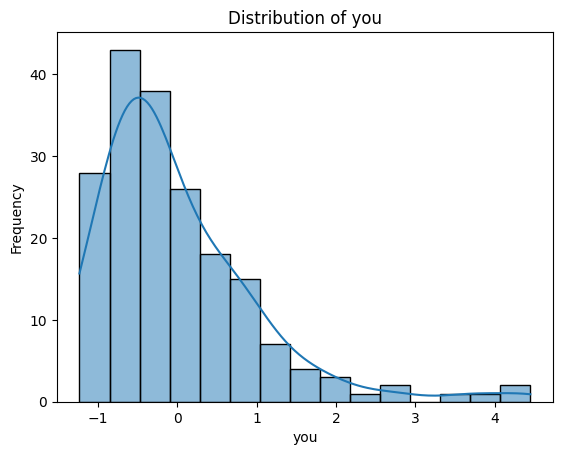

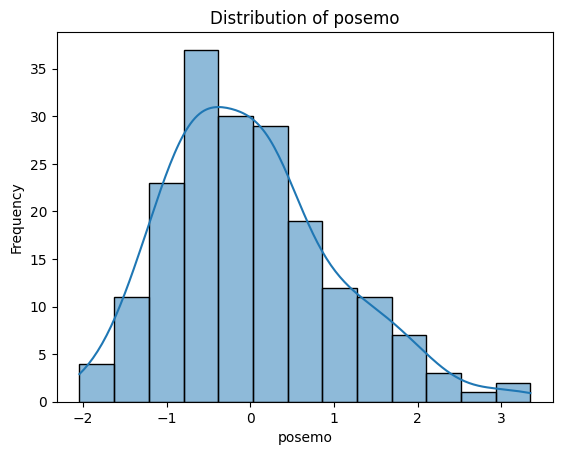

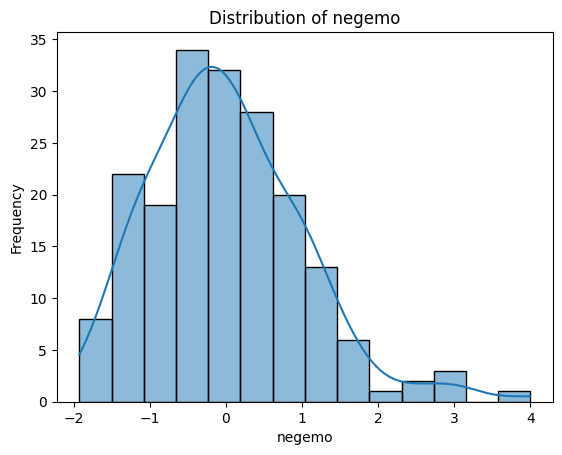

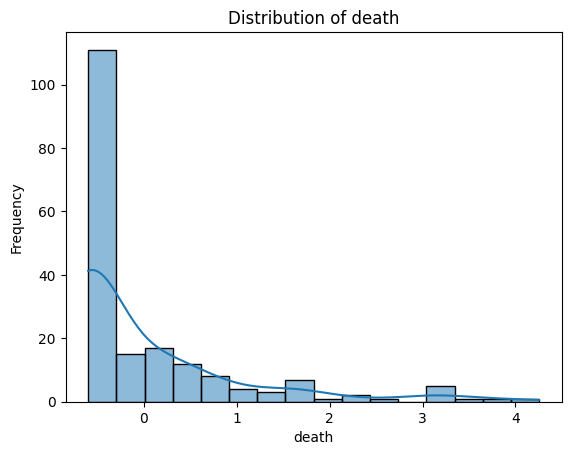

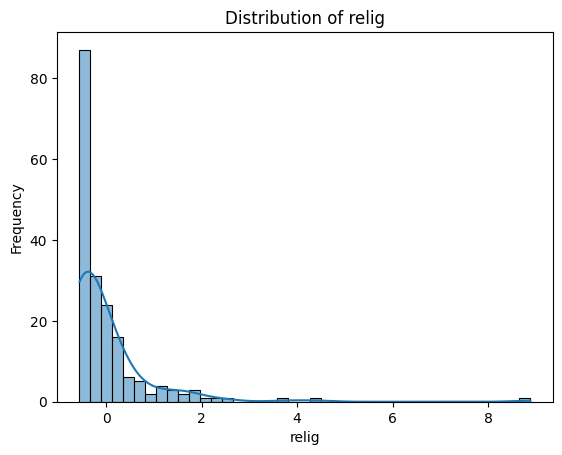

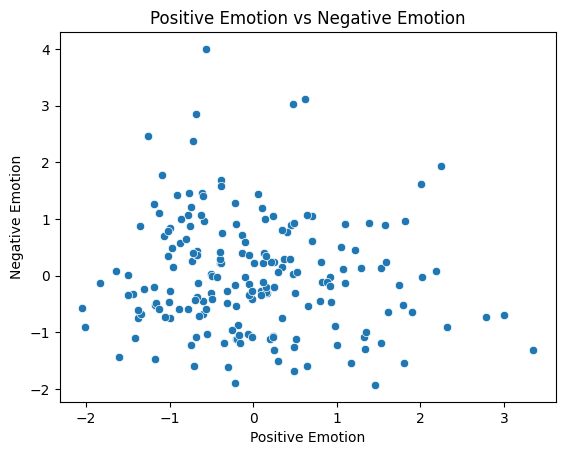

In [ ]:
## Statistical analysis on LIWC features:

# Selecting relevant columns for mental health analysis
cols_of_interest = ['Filename', 'WC', 'affect', 'anx', 'anger', 'sad', 'Tone', 'cogproc', 'i', 'we', 'you', 'posemo', 'negemo', 'death', 'relig']
filtered_data = norm_liwc_data_specified[cols_of_interest]

# Display basic statistics
print(filtered_data.describe())

# Correlation matrix of selected metrics
correlation_matrix = filtered_data.iloc[:, 1:].corr()  # Excluding 'Filename'
print(correlation_matrix)

# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of LIWC Metrics')
plt.show()

# Distribution plots for key metrics
# Iterate over the chosen columns
for column in cols_of_interest[1:]:  # Excluding 'Filename'
    plt.figure()
    sns.histplot(filtered_data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Scatter plot for given metrics (e.g. 'posemo' vs 'negemo')
plt.figure()
sns.scatterplot(data=filtered_data, x='posemo', y='negemo')
plt.title('Positive Emotion vs Negative Emotion')
plt.xlabel('Positive Emotion')
plt.ylabel('Negative Emotion')
plt.show()

# GloVe Embeddings:

Extracting GloVe embeddings as a feature:

In [ ]:
'''
GloVe website ( https://nlp.stanford.edu/projects/glove/ ).
- The 100d model offers a good balance.
    Alternatively, although a bit more computationaly intensive, the 200d model can be used as well.
- The "Wikipedia 2014 + Gigaword 5" GloVe model
'''

In [ ]:
## text_processing

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text_for_glove(text):
    tokens = word_tokenize(text.lower())
    return ' '.join(tokens)

# def preprocess_text_for_bow_tfidf(text):
#     text = text.lower()
#     text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
#     tokens = word_tokenize(text)
#     return ' '.join([token for token in tokens if token not in stop_words])

# Apply preprocessing
merged_dfs['ProcessedTextForGlove'] = merged_dfs['CleanedText'].apply(preprocess_text_for_glove)

In [ ]:
## Load the glove model

def load_glove_model(glove_file_path):
    glove_model = {}
    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
    return glove_model

# Setting glove path and initiating glove model
glove_dir = '/content/drive/My Drive/DAIC-Woz/glove.6B/glove.6B.100d.txt'
glove_model = load_glove_model(glove_dir)

In [ ]:
## Convert the preprocessed texts into GloVe vectors. We'll use the column 'ProcessedTextForGlove' from the merged_dfs DataFrame

def text_to_gloves(text, glove_model):
    words = text.split()
    word_vectors = [glove_model.get(word, np.zeros((100,))) for word in words]  # 100 is the dimensions of GloVe vectors
    return np.mean(word_vectors, axis=0)  # Using mean vector for the sentence

# Applying the function to each text in your DataFrame
merged_dfs['GloVeVector'] = merged_dfs['ProcessedTextForGlove'].apply(lambda x: text_to_gloves(x, glove_model))

In [ ]:
## Saving the extracted GloVe embeddings:

# Create a new DataFrame with GloVe vectors
glove_vectors_df = pd.DataFrame(merged_dfs['GloVeVector'].tolist())

# Include the 'Filename' column as an identifier
glove_vectors_df['Filename'] = merged_dfs['Filename']

# Reorder columns to have 'Filename' as the first column
column_order = ['Filename'] + [col for col in glove_vectors_df.columns if col != 'Filename']
glove_vectors_df = glove_vectors_df[column_order]

# Save the GloVe vectors DataFrame to a CSV file
glove_vectors_df.to_csv('/content/drive/My Drive/DAIC-Woz/extracted-glove-vectors.csv', index=False)

Normalizing the GloVe embeddings:

In [ ]:
# Load the extracted GloVe Embeddings - to save time from executing all the previous code till this point:
glove_vectors_df = pd.read_csv('/content/drive/My Drive/DAIC-Woz/extracted-glove-vectors.csv')

# Since 'Filename' isn't numerical, let's exclude it
glove_numeric_data = glove_vectors_df.drop(columns=['Filename'])

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the GloVe embeddings and transform them
# This normalizes each dimension of the GloVe embeddings
normalized_glove_embeddings = scaler.fit_transform(glove_numeric_data)

# Recreate the DataFrame with the 'Filename' column
normalized_glove_embeddings_df = pd.DataFrame(normalized_glove_embeddings, columns=[f'glove_dim_{i}' for i in range(glove_numeric_data.shape[1])])
"""
- shape[0] is the number of rows (i.e., the number of samples or GloVe vectors)
- the second element (shape[1]) is the number of columns (i.e., the dimensions of each GloVe vector)
"""
normalized_glove_embeddings_df.insert(0, 'Filename', glove_vectors_df['Filename'])

# Save the normalized GloVe vectors DataFrame to a new CSV file
normalized_glove_embeddings_df.to_csv('/content/drive/My Drive/DAIC-Woz/extracted-glove-vectors-normalized.csv', index=False)

Combine with LIWC to create the features set:

In [ ]:
# Load the final LIWC dataframe
norm_liwc_data = pd.read_csv('/content/drive/My Drive/DAIC-Woz/specified-liwc-data-normalized-and-clustered.csv')

# Sort both Dataframes on 'Filename' to make sure that we have the same order in both, before alignment
norm_liwc_data_sorted = norm_liwc_data.sort_values(by='Filename').reset_index(drop=True)
normalized_glove_embeddings_df_sorted = normalized_glove_embeddings_df.sort_values(by='Filename').reset_index(drop=True)

# Concatenate PCA-transformed LIWC features with normalized GloVe embeddings
combined_features = pd.concat([norm_liwc_data_sorted,
                               normalized_glove_embeddings_df_sorted.drop(columns=['Filename'])], # drop the duplicate 'Filename' column
                              axis=1)

# Save the combined-normalized features set
combined_features.to_csv('/content/drive/My Drive/DAIC-Woz/final-text-feature_set.csv', index=False)

# Extra feature engineering based on Pos-tags:

In [ ]:
nltk.download('punkt')  # For tokenization
nltk.download('averaged_perceptron_tagger')  # For POS tagging

# Define the directory
dir_path = '/content/drive/My Drive/DAIC-Woz/cleaned-txt'

# Initialize a list to store the data
data = []

# Function to tokenize and POS tag text
def tokenize_and_tag(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    return tagged

# Loop through each file in the directory
for filename in os.listdir(dir_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(dir_path, filename)

        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            # Tokenize and POS tag the text
            tagged_text = tokenize_and_tag(text)
            # Convert list of tuples to JSON string
            tagged_text_json = json.dumps(tagged_text)
            # Append the results to the data list, now with the JSON string
            data.append({'Filename': filename, 'Tokenized_and_Tagged': tagged_text_json})

# Convert the list to a DataFrame
pos_tags_df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
pos_tags_df.to_csv('/content/drive/My Drive/DAIC-Woz/tokenized_and_tagged_texts.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Convert JSON strings back to lists of tuples
pos_tags_df['Tokenized_and_Tagged'] = pos_tags_df['Tokenized_and_Tagged'].apply(json.loads)

# Print the first few rows to verify the process completion
print(pos_tags_df.head())

                     Filename  \
0  300_CLEANED_TRANSCRIPT.txt   
1  301_CLEANED_TRANSCRIPT.txt   
2  304_CLEANED_TRANSCRIPT.txt   
3  303_CLEANED_TRANSCRIPT.txt   
4  302_CLEANED_TRANSCRIPT.txt   

                                Tokenized_and_Tagged  
0  [[good, JJ], [atlanta, NN], [georgia, NN], [um...  
1  [[thank, NN], [you, PRP], [mmm, VBP], [k, VB],...  
2  [[i, NN], ['m, VBP], [doing, VBG], [good, JJ],...  
3  [[okay, VB], [how, WRB], ['bout, JJ], [yoursel...  
4  [[i, NN], ['m, VBP], [fine, JJ], [how, WRB], [...  


In [ ]:
# Pronouns to count
first_person_singular_pronouns = ['i', 'me', 'my']
third_person_singular_pronouns = ['he', 'she', 'it', 'his', 'her','hers']
third_person_plural_pronouns = ['they', 'them', 'their', 'theirs']

# Function to count occurrences of specific pronouns
def count_pronouns(pos_tags_list, pronouns_list):
    return sum(word.lower() in pronouns_list for word, _ in pos_tags_list)

# Apply the function to count pronouns and create new columns
pos_tags_df['1st_Sg_Count'] = pos_tags_df['Tokenized_and_Tagged'].apply(lambda x: count_pronouns(x, first_person_singular_pronouns))
pos_tags_df['3rd_Sg_Count'] = pos_tags_df['Tokenized_and_Tagged'].apply(lambda x: count_pronouns(x, third_person_singular_pronouns))
pos_tags_df['3rd_Pl_Count'] = pos_tags_df['Tokenized_and_Tagged'].apply(lambda x: count_pronouns(x, third_person_plural_pronouns))

# Count specific POS tags
relevant_pos_tags = [
    'PRP', 'PRP$', 'NN', 'NNS', 'NNP', 'NNPS',
    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',
    'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS',
    'UH'
]

# Function to count occurrences of specific POS tags
def count_relevant_tags(pos_tags_list, tag_list):
    tag_counter = Counter(tag for _, tag in pos_tags_list if tag in tag_list)  # using '_' since we only care for the 'tag' part of each tuple
    return tag_counter

# Apply the function to count POS tags and add to DataFrame
for tag in relevant_pos_tags:
    pos_tags_df[tag + '_Count'] = pos_tags_df['Tokenized_and_Tagged'].apply(lambda x: count_relevant_tags(x, [tag]).get(tag, 0))

# Save the modified DataFrame to a new CSV file
pos_tags_df.to_csv('/content/drive/My Drive/DAIC-Woz/tokenized_and_tagged_texts-with_counts.csv', index=False)

Normalize POS-TAG results:

In [ ]:
# Once again we have to exclude all non-numerical columns prior to normalizing
non_numerical_columns = ['Filename', 'Tokenized_and_Tagged']

# Select columns to normalize
columns_to_normalize = [col for col in pos_tags_df.columns if col not in non_numerical_columns]

# Normalize the selected columns
scaler = StandardScaler()

pos_tags_df[columns_to_normalize] = scaler.fit_transform(pos_tags_df[columns_to_normalize])

# Save to a csv file:
pos_tags_df.to_csv('/content/drive/My Drive/DAIC-Woz/tokenized_and_tagged_texts-with_counts-normalized.csv', index=False)

Merge with my previous feature set:

In [ ]:
# Load the existing normalized feature set
liwc_and_gloves_df = pd.read_csv('/content/drive/My Drive/DAIC-Woz/final-text-feature_set.csv')

# Merge with pos tag counts
final_merge_df = pd.merge(liwc_and_gloves_df, pos_tags_df, on='Filename', how='inner')

# Check the first few rows to verify the merge was successful
print(final_merge_df.head())

# Save this merged DataFrame to a new CSV file
final_merge_df.to_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set.csv', index=False)

                     Filename        WC      Tone    affect    posemo  \
0  300_CLEANED_TRANSCRIPT.txt -1.386294  1.147714  2.458719  3.001837   
1  301_CLEANED_TRANSCRIPT.txt -0.001759  0.553877 -0.571142 -0.181046   
2  302_CLEANED_TRANSCRIPT.txt -1.061175  0.930318 -0.414317  0.246008   
3  303_CLEANED_TRANSCRIPT.txt  0.610155  0.531672 -0.853427 -0.354536   
4  304_CLEANED_TRANSCRIPT.txt -0.601312  0.628752 -0.552323 -0.201064   

     negemo       anx     anger       sad         i  ...  RBR_Count  \
0 -0.684487 -0.344099  0.309090 -1.197029  0.931616  ...  -0.569930   
1 -0.867948 -0.387806  0.213584 -0.791256  0.764444  ...  -0.569930   
2 -1.305431 -0.868574 -0.996164 -0.527504 -1.904919  ...  -1.116715   
3 -1.178420 -1.130811 -0.709645 -0.568082 -1.306334  ...  -0.023144   
4 -1.121970 -1.567873  0.118078 -0.791256 -0.200841  ...   0.250248   

   RBS_Count  UH_Count  DT_Count  WDT_Count  WP_Count  WP$_Count  WRB_Count  \
0  -0.663738  0.608942 -1.362745  -0.859103 -0.931781  

Finding the most common words per interview:

In [ ]:
nltk.download('stopwords')

# Path to the directory containing all cleaned interview texts
directory_path = '/content/drive/My Drive/DAIC-Woz/cleaned-txt'

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

# Function to process each text file
def process_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Load filenames and their corresponding texts
filenames = [filename for filename in os.listdir(directory_path) if filename.endswith('.txt')]
texts = [process_text_file(os.path.join(directory_path, filename)) for filename in filenames]

# Fit and transform the texts with TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to get top N TF-IDF words for a document
def get_top_n_words(doc_id, top_n=20):
    # Sort words in document by their TF-IDF scores
    sorted_items = sorted(zip(tfidf_matrix[doc_id].toarray()[0], feature_names), reverse=True)
    # Get top N words and their scores
    top_n_words = [(score, word) for score, word in sorted_items[:top_n]]
    return top_n_words

# Create a DataFrame to store results
tfidf_results = pd.DataFrame(columns=['Filename', 'Top_TF-IDF_Words'])

data_for_df = []

# Inside the loop add a dictionary to the list
for i, filename in enumerate(filenames):
    top_words = get_top_n_words(i, 20)
    # Convert list of tuples to a readable string format
    top_words_str = ', '.join([f"{word} ({round(score, 3)})" for score, word in top_words])
    data_for_df.append({'Filename': filename, 'Top_TF-IDF_Words': top_words_str})

# After the loop, create a DataFrame from the list of dictionaries
tfidf_results = pd.DataFrame(data_for_df)

# Save the results to a CSV file
tfidf_results.to_csv('/content/drive/My Drive/DAIC-Woz/tf-idf_results.csv', index=False)

# Print the DataFrame
print(tfidf_results.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                     Filename  \
0  300_CLEANED_TRANSCRIPT.txt   
1  301_CLEANED_TRANSCRIPT.txt   
2  304_CLEANED_TRANSCRIPT.txt   
3  303_CLEANED_TRANSCRIPT.txt   
4  302_CLEANED_TRANSCRIPT.txt   

                                    Top_TF-IDF_Words  
0  um (0.414), uh (0.296), diploma (0.233), frien...  
1  think (0.313), like (0.281), know (0.198), mea...  
2  um (0.34), yeah (0.305), guess (0.18), comes (...  
3  know (0.523), like (0.242), um (0.22), kids (0...  
4  uh (0.276), um (0.186), mom (0.145), yesterday...  


# Creating Labels for the dataset:

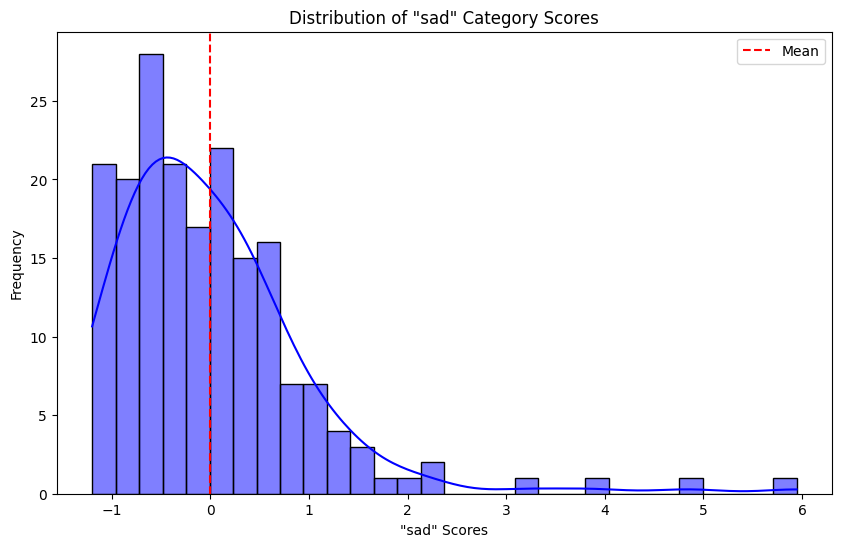

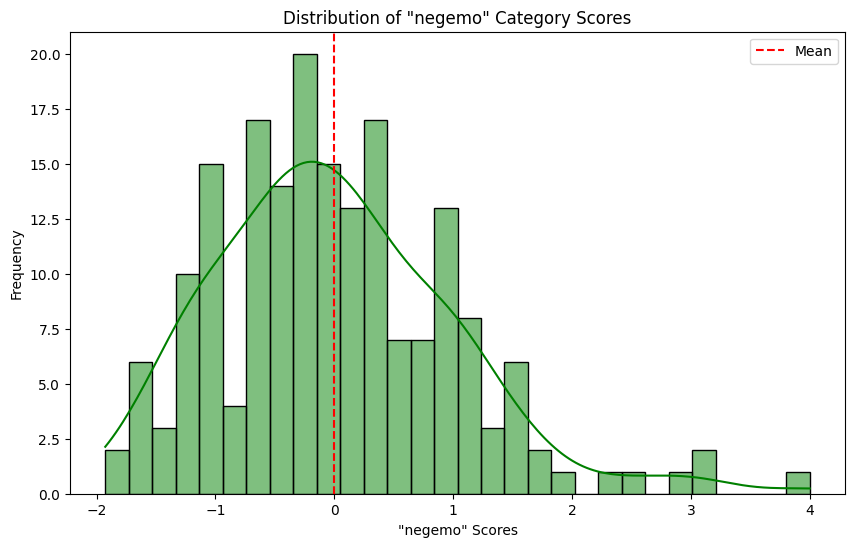

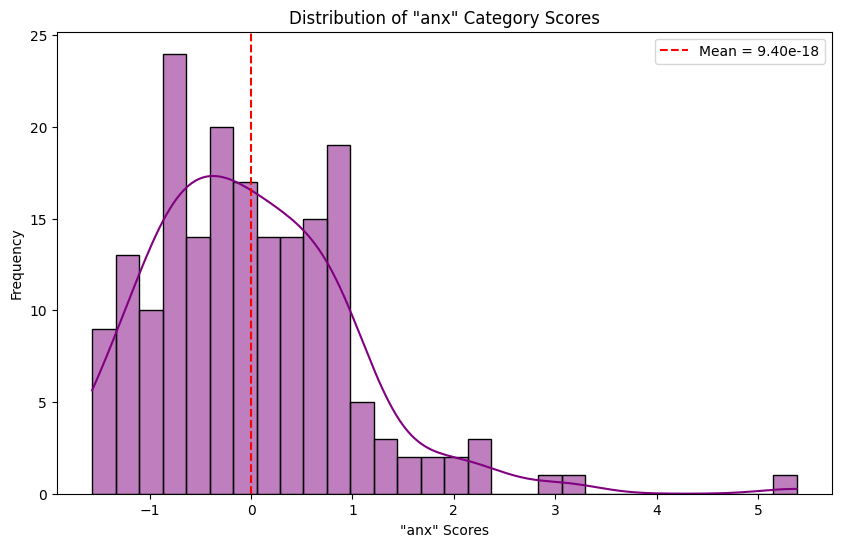

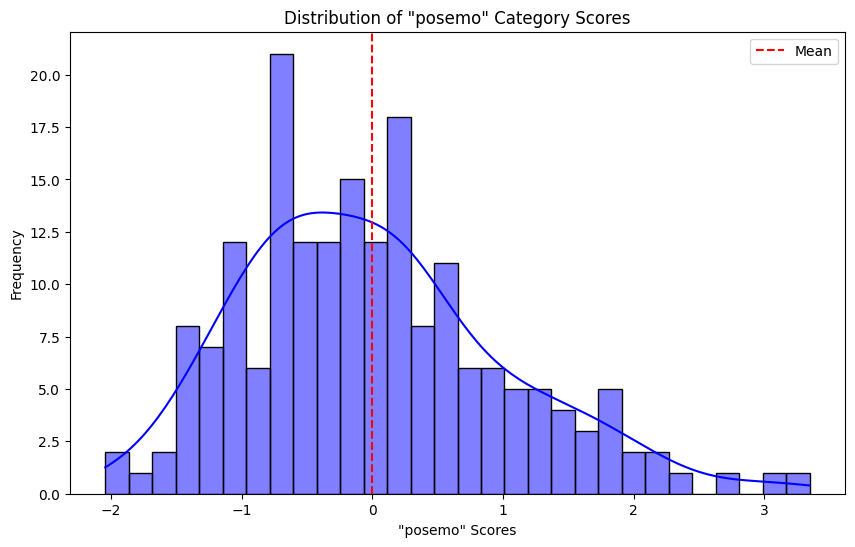

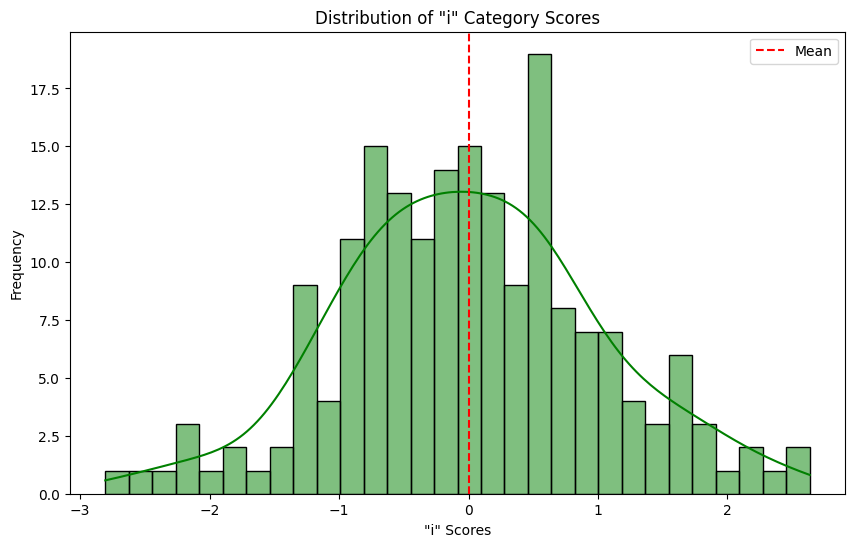

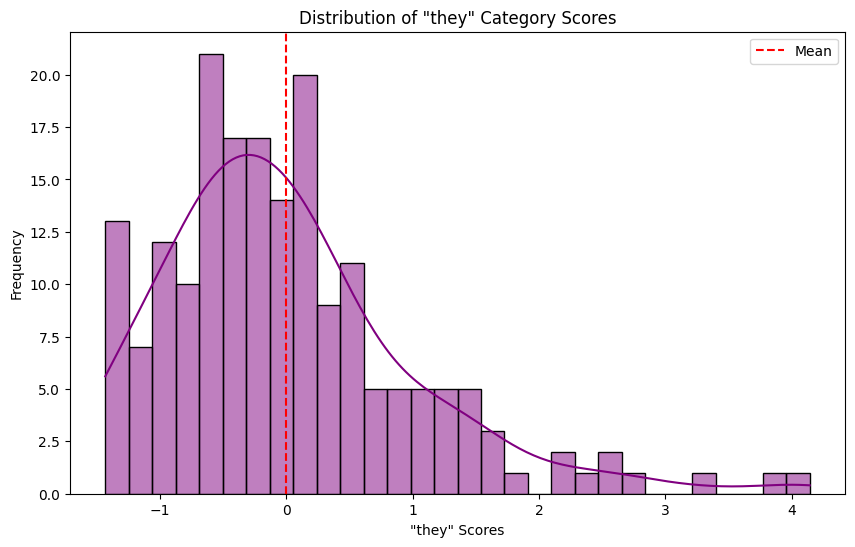

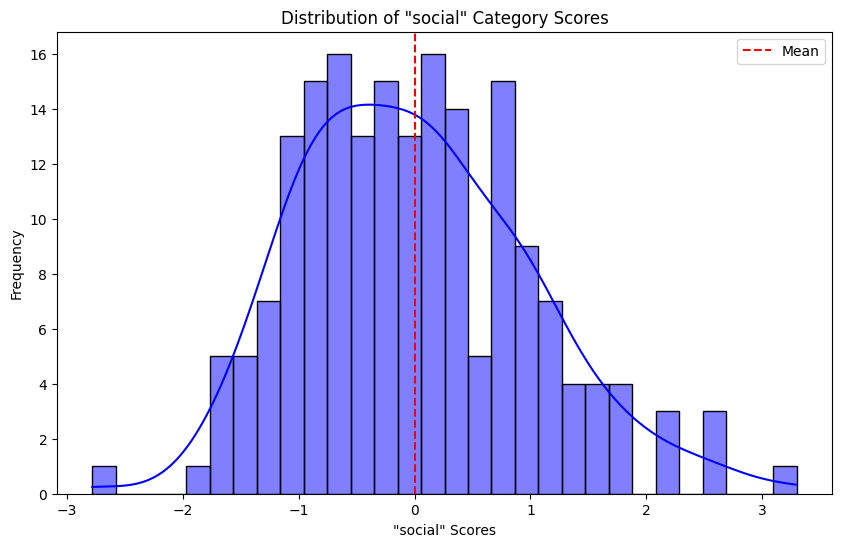

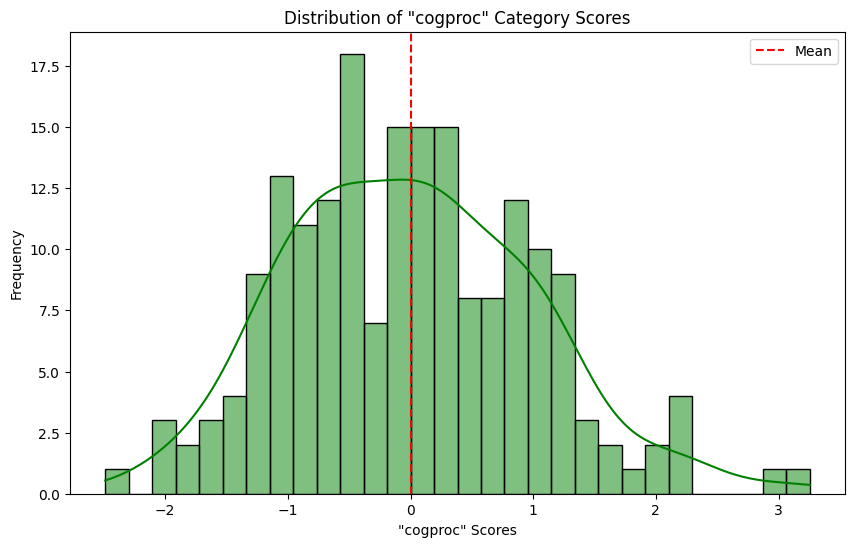

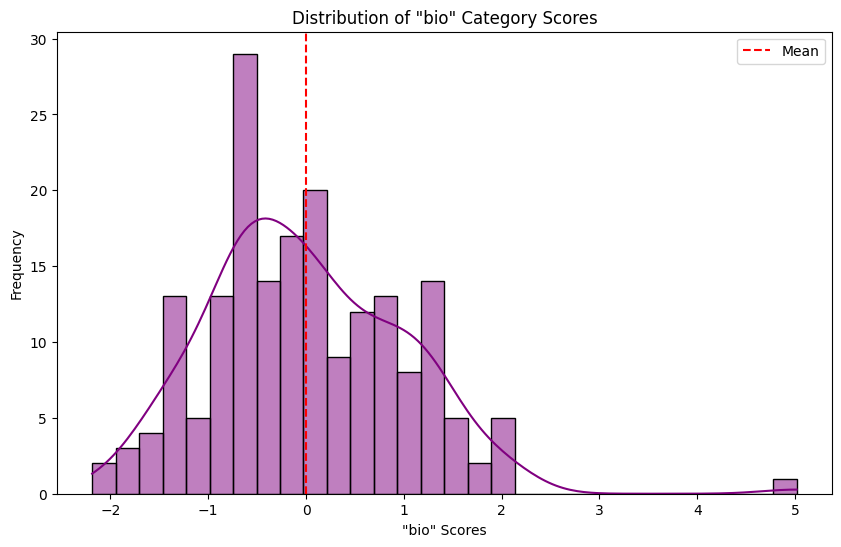

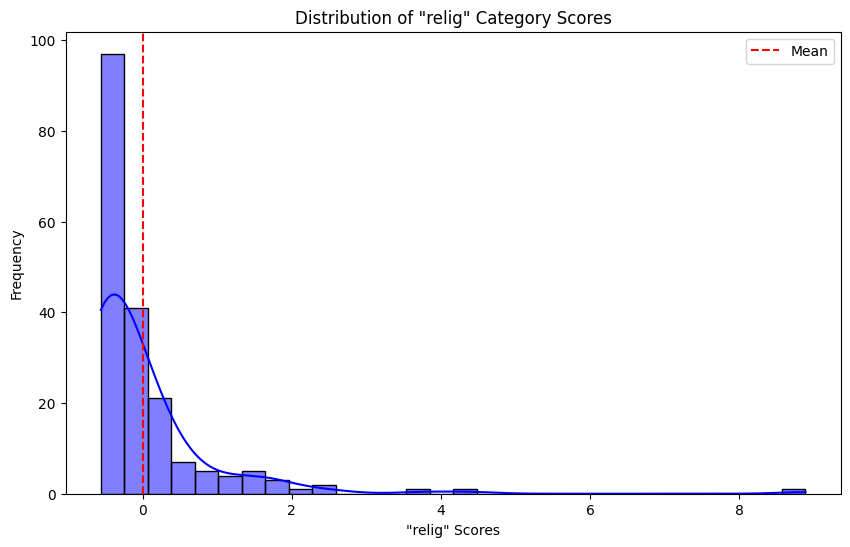

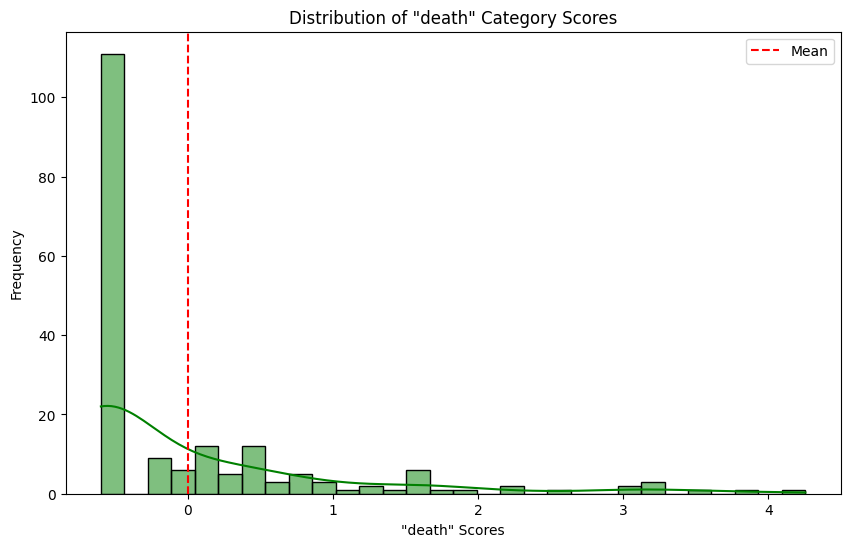

In [ ]:
## Plotting the Distributions to Determine Appropriate Thresholds for Labeling

norm_liwc_data = pd.read_csv('/content/drive/My Drive/DAIC-Woz/specified-LIWC-data-normalized.csv')

# Declare the categories of interest
categories_for_distribution = ['sad', 'negemo', 'anx', 'posemo', 'i', 'they', 'social', 'cogproc', 'bio', 'relig', 'death']

# Plotting the distribution for each category
for category in categories_for_distribution:
    plt.figure(figsize=(10, 6))
    sns.histplot(norm_liwc_data[category], kde=True, bins=30, color='green')
    plt.title(f'Distribution of "{category}" Category Scores')
    plt.xlabel(f'"{category}" Scores')
    plt.ylabel('Frequency')
    plt.axvline(norm_liwc_data[category].mean(), color='red', linestyle='--', label='Mean')
    plt.legend()
    plt.show()

In [ ]:
## summary statistics for the LIWC categories:

statistics_summary = norm_liwc_data_labels.describe(include=[np.number])  # Provides count, mean, std, min, quartiles, max

skewness = norm_liwc_data_labels.skew()
kurtosis = norm_liwc_data_labels.kurtosis()

print("Summary Statistics:\n", statistics_summary)
print("\nSkewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Summary Statistics:
                  WC          Tone        affect        posemo        negemo  \
count  1.890000e+02  1.890000e+02  1.890000e+02  1.890000e+02  1.890000e+02   
mean   1.174839e-18  5.639228e-17  3.759485e-17  2.819614e-16  2.208698e-16   
std    1.002656e+00  1.002656e+00  1.002656e+00  1.002656e+00  1.002656e+00   
min   -1.614989e+00 -2.958027e+00 -2.346402e+00 -2.042732e+00 -1.926375e+00   
25%   -7.175142e-01 -7.153864e-01 -5.899611e-01 -7.015171e-01 -6.703747e-01   
50%   -2.218015e-01  2.900064e-01 -9.439378e-02 -1.343368e-01 -1.199924e-01   
75%    4.717018e-01  8.714508e-01  6.144557e-01  4.995706e-01  5.997382e-01   
max    3.883590e+00  1.147714e+00  2.904102e+00  3.348817e+00  4.000818e+00   

                anx         anger           sad             i            we  \
count  1.890000e+02  1.890000e+02  1.890000e+02  1.890000e+02  1.890000e+02   
mean   9.398713e-18 -4.605370e-16 -1.586033e-16  1.456801e-16 -7.284003e-17   
std    1.002656e+00  1.002656e

<ipython-input-19-3c3bf1b9870b>:4: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = norm_liwc_data_labels.skew()
<ipython-input-19-3c3bf1b9870b>:5: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  kurtosis = norm_liwc_data_labels.kurtosis()


In [ ]:
## Approach: Identify as a marker as long as even one of the thresholds is exceeded
"""
Advantages: Sensitivity (captures a wider range of potential markers) and Simplicity
Disadvantage: Specificity (risk of including false-positives)
"""

thresholds = {
    'negemo': 1.9, # A middle ground between the thresholds of Sets 7 and 8
    'anx': 2.25,
    'sad': 2.25,
    'i': 1.5, # Slightly less strict than Set 7 to potentially capture a broader array of self-referential language
    'they': 1.75,
    'social': {'lower': -2, 'upper': 2},
    'cogproc': {'lower': -2, 'upper': 2},
    'bio': 1.75, # Slightly more inclusive than Set 7, reflecting insights from Set 8
    'relig': 2.75, # Reflecting the very high threshold from Set 8 for this less directly related category
    'death': 2.25, # A compromise between the strictness of Set 7 and the insights of Sets 8 and 11
}

def apply_thresholds(row, thresholds):
    exceeded_categories = []
    for category, threshold in thresholds.items():
        if isinstance(threshold, dict):  # For dual thresholds
            if row[category] < threshold['lower'] or row[category] > threshold['upper']:
                exceeded_categories.append(category)
        else:  # For single thresholds
            if row[category] > threshold:
                exceeded_categories.append(category)
    # Return both the binary label (1 if any category is exceeded) and the exceeded categories
    return 1 if exceeded_categories else 0, exceeded_categories


# Applying the function and creating a new DataFrame column for the results
norm_liwc_data['Results'] = norm_liwc_data.apply(lambda row: apply_thresholds(row, thresholds), axis=1)

# Splitting the 'Results' into 'Marker' and 'Exceeded_Categories'
norm_liwc_data['Marker'], norm_liwc_data['Exceeded_Categories'] = zip(*norm_liwc_data['Results'])

# Drop the 'Results' column
norm_liwc_data.drop(columns=['Results'], inplace=True)

# Saving in new csv along with labels:
norm_liwc_data.to_csv('/content/drive/My Drive/DAIC-Woz/specified-liwc-data-normalized-and-labeled.csv', index=False)

In [ ]:
## Analyze the "Exceeded_Categories" column to aggregate information on the most commonly exceeded thresholds

# Flatten the list of all exceeded categories for rows where a marker is present
all_exceeded = [category for sublist in norm_liwc_data[norm_liwc_data['Marker'] == 1]['Exceeded_Categories'] for category in sublist]

# Count the frequency of each category being exceeded
exceeded_counts = Counter(all_exceeded)

# Print the most common exceeded categories
print(exceeded_counts.most_common())

[('i', 15), ('they', 10), ('cogproc', 9), ('death', 9), ('social', 8), ('negemo', 7), ('bio', 7), ('anx', 6), ('sad', 4), ('relig', 3)]


In [ ]:
## Comparison between Marker presence and absence to identify the best set of thresholds

label_counts = norm_liwc_data['Marker'].value_counts()
print(label_counts)

label_proportions = norm_liwc_data['Marker'].value_counts(normalize=True)
print(label_proportions)

0    129
1     60
Name: Marker, dtype: int64
0    0.68254
1    0.31746
Name: Marker, dtype: float64


In [ ]:
# experimental threshold sets:

"""
Set 0: Starting setup
thresholds = {
    #'posemo': 1.5,  # Adjusted for stricter criteria
    'negemo': 1.5,  # Higher to ensure only significant negative emotion is captured
    'anx': 1.5,     # Adjusted for more pronounced anxiety markers
    'sad': 1.5,     # Higher to focus on more significant indications of sadness
    'i': 1.5,       # Stricter to capture pronounced self-focus
    'they': 1.5,    # Adjusted upwards
    'social': {'lower': -1.5, 'upper': 1.5},  # Dual threshold for more pronounced cases
    'cogproc': {'lower': -1.5, 'upper': 1.5}, # Dual threshold, adjusted for stricter identification
    'bio': 1.5,     # To capture significant mentions related to physical symptoms
    'relig': 0.5,   # Slightly stricter, considering its less direct association
    'death': 1.5    # Higher to capture more explicit references
}

Set 1:
thresholds_set_1 = {
    #'posemo': 1.2,
    'negemo': 1.2,
    'anx': 1.2,
    'sad': 1.2,
    'i': 1,
    'they': 1.2,
    'social': {'lower': -1.2, 'upper': 1.2},
    'cogproc': {'lower': -1, 'upper': 1},
    'bio': 1.2,
    'relig': 0.4,
    'death': 1.2
}

Set 2: Balanced Thresholds
Aiming for a balance between sensitivity and specificity, potentially useful for datasets where the distribution of scores is more evenly spread, and
the risk of missing relevant instances (false negatives) is a concern.
thresholds_set_2 = {
    #'posemo': 1,
    'negemo': 1,
    'anx': 1,
    'sad': 1,
    'i': 0.8,
    'they': 1,
    'social': {'lower': -1, 'upper': 1},
    'cogproc': {'lower': -0.8, 'upper': 0.8},
    'bio': 1,
    'relig': 0.3,
    'death': 1
}

Set 3: A bit stricter than the starting Thresholds
thresholds_moderately_strict = {
    #'posemo': 2,
    'negemo': 2,
    'anx': 2,
    'sad': 2,
    'i': 1.5,
    'they': 2,
    'social': {'lower': -2, 'upper': 2},
    'cogproc': {'lower': -2, 'upper': 2},
    'bio': 2,
    'relig': 1,  # Adjusted considering the wider distribution in relig
    'death': 2
}

Set 4: revised sensitive thresholds
This adjustment aims to better reflect a sensitivity-oriented approach, with thresholds set to more inclusively identify potential markers.
thresholds_revised_sensitive = {
    #'posemo': 0.5,
    'negemo': 0.5,
    'anx': 0.8,
    'sad': 0.8,
    'i': 0.5,
    'they': 0.8,
    'social': {'lower': -0.5, 'upper': 0.8},
    'cogproc': {'lower': -0.5, 'upper': 0.8},
    'bio': 0.8,
    'relig': 0.2,
    'death': 0.5
}

Set 5: Very Strict Thresholds
Focusing on very pronounced deviations, which are likely to capture only the most extreme cases.
thresholds_very_strict = {
    #'posemo': 2.5,
    'negemo': 2.5,
    'anx': 2.5,
    'sad': 2.5,
    'i': 2,
    'they': 2.5,
    'social': {'lower': -2.5, 'upper': 2.5},
    'cogproc': {'lower': -2.5, 'upper': 2.5},
    'bio': 2.5,
    'relig': 1.5,  # Given relig's max is much higher, adjusted less strictly
    'death': 2.5
}

Set 6: Refined Thresholds based on statistics found earlier on LIWC categories (normalized)
thresholds_refined = {
    #'posemo': 1.75,  # Considering max at 3.348817, tighter than previous but still strict
    'negemo': 1.75,  # Given max at 4.000818, allows for capturing higher deviations
    'anx': 1.75,     # Max at 5.381410 suggests significant outliers could be relevant
    'sad': 1.75,     # Max at 5.944568 indicates the presence of extreme cases
    'i': 1.5,        # Adjusted for max at 2.635695, aiming to be strict yet reasonable
    'they': 1.75,    # With a more moderated max, threshold is set to be inclusively strict
    'social': {'lower': -1.75, 'upper': 1.75},  # Dual thresholds for broader coverage
    'cogproc': {'lower': -1.75, 'upper': 1.75}, # Considering cognitive processing variability
    'bio': 1.75,     # Max at 2.904102, set for capturing significant biological mentions
    'relig': 1,      # Given a high max but less direct relation to mental health, set lower
    'death': 1.75    # Max at 4.255017, aimed at capturing pronounced references
}

Set 7: Revised thresholds based on the summary statistics and the distribution plots:
revised_thresholds = {
    'negemo': 2,  # Considering the positive skew and the need to capture significant deviations
    'anx': 2.5,   # High skewness and kurtosis suggest setting a higher threshold
    'sad': 2.5,   # Very high kurtosis and max values indicate the presence of significant outliers
    'i': 1.5,     # Adjust based on distribution, keeping it more moderate
    'they': 2,    # Adjusted considering distribution characteristics
    'social': {'lower': -2, 'upper': 2},  # Dual threshold to capture both extremes
    'cogproc': {'lower': -2, 'upper': 2}, # Given the distribution, adjusted to capture significant deviations
    'bio': 2,     # High max value indicates a need for a higher threshold
    'relig': 3,   # Extremely high kurtosis, setting a very high threshold to capture the most extreme cases
    'death': 2.5  # High kurtosis and skewness, indicating the presence of outliers
}

Set 8: Refined Statistical Approach
Lower the thresholds slightly from the "revised_thresholds" set, aiming to capture significant markers without being overly inclusive.
thresholds_refined_a = {
    'negemo': 2, 'anx': 2.25, 'sad': 2.25, 'i': 1.25, 'they': 1.75,
    'social': {'lower': -2, 'upper': 2}, 'cogproc': {'lower': -2, 'upper': 2},
    'bio': 1.75, 'relig': 2.75, 'death': 2
}

Set 9: Moderately Inclusive
Aim for a middle ground between Sets 0 and 3, slightly adjusting thresholds to be less strict than Set 8 but more than the original Set 0.
thresholds_moderate_b = {
    'negemo': 1.75, 'anx': 1.75, 'sad': 1.75, 'i': 1.25, 'they': 1.5,
    'social': {'lower': -1.5, 'upper': 1.5}, 'cogproc': {'lower': -1.5, 'upper': 1.5},
    'bio': 1.5, 'relig': 1, 'death': 1.5
}

Set 10: Conservatively Sensitive
Slightly more inclusive than Set 8
thresholds_conservative_c = {
    'negemo': 1.5, 'anx': 2, 'sad': 2, 'i': 1.25, 'they': 1.5,
    'social': {'lower': -1.75, 'upper': 1.75}, 'cogproc': {'lower': -1.75, 'upper': 1.75},
    'bio': 1.5, 'relig': 2.5, 'death': 1.75
}

Set 11 (Balanced Sensitivity):
Aim for thresholds that likely capture the more pronounced markers, aligning the proportion of '1s' closer to 30-40%,
allowing for some buffer given the imperfect correlation between linguistic markers and clinical depression.
thresholds_balanced_a = {
    'negemo': 2, 'anx': 2.25, 'sad': 2.25, 'i': 1.5, 'they': 2,
    'social': {'lower': -2, 'upper': 2}, 'cogproc': {'lower': -2, 'upper': 2},
    'bio': 2, 'relig': 2, 'death': 2
}

Set 12 (Increased Specificity):
Set thresholds to be slightly stricter, potentially reducing the proportion of '1s' to closely match or be slightly above the 30% prevalence.
This approach favors specificity, reducing the risk of false positives.
thresholds_specific_b = {
    'negemo': 2.25, 'anx': 2.5, 'sad': 2.5, 'i': 1.75, 'they': 2.25,
    'social': {'lower': -2.25, 'upper': 2.25}, 'cogproc': {'lower': -2.25, 'upper': 2.25},
    'bio': 2.25, 'relig': 2.5, 'death': 2.5
}

Set 13 (Moderate Sensitivity):
Choose a middle ground that leans towards sensitivity, capturing a broader array of potential markers while still being mindful of the 30% prevalence.
thresholds_moderate_c = {
    'negemo': 1.75, 'anx': 2, 'sad': 2, 'i': 1.25, 'they': 1.75,
    'social': {'lower': -1.75, 'upper': 1.75}, 'cogproc': {'lower': -1.75, 'upper': 1.75},
    'bio': 1.75, 'relig': 1.5, 'death': 1.75
}

Set 14: Created based on the refinement of the top 3 selected threshold sets - COMPOSITE set
thresholds = {
    'negemo': 1.9, # A middle ground between the thresholds of Sets 7 and 8
    'anx': 2.25,
    'sad': 2.25,
    'i': 1.4, # Slightly less strict than Set 7 to potentially capture a broader array of self-referential language
    'they': 1.75,
    'social': {'lower': -2, 'upper': 2},
    'cogproc': {'lower': -2, 'upper': 2},
    'bio': 1.75, # Slightly more inclusive than Set 7, reflecting insights from Set 8
    'relig': 2.75, # Reflecting the very high threshold from Set 8 for this less directly related category
    'death': 2.25, # A compromise between the strictness of Set 7 and the insights of Sets 8 and 11
}

Set 15: slight modification on the composite set (category 'i')
thresholds = {
    'negemo': 1.9, # A middle ground between the thresholds of Sets 7 and 8
    'anx': 2.25,
    'sad': 2.25,
    'i': 1.5, # Slightly less strict than Set 7 to potentially capture a broader array of self-referential language
    'they': 1.75,
    'social': {'lower': -2, 'upper': 2},
    'cogproc': {'lower': -2, 'upper': 2},
    'bio': 1.75, # Slightly more inclusive than Set 7, reflecting insights from Set 8
    'relig': 2.75, # Reflecting the very high threshold from Set 8 for this less directly related category
    'death': 2.25, # A compromise between the strictness of Set 7 and the insights of Sets 8 and 11
}
"""

'\nSet 0: Starting setup\nthresholds = {\n    #\'posemo\': 1.5,  # Adjusted for stricter criteria\n    \'negemo\': 1.5,  # Higher to ensure only significant negative emotion is captured\n    \'anx\': 1.5,     # Adjusted for more pronounced anxiety markers\n    \'sad\': 1.5,     # Higher to focus on more significant indications of sadness\n    \'i\': 1.5,       # Stricter to capture pronounced self-focus\n    \'they\': 1.5,    # Adjusted upwards\n    \'social\': {\'lower\': -1.5, \'upper\': 1.5},  # Dual threshold for more pronounced cases\n    \'cogproc\': {\'lower\': -1.5, \'upper\': 1.5}, # Dual threshold, adjusted for stricter identification\n    \'bio\': 1.5,     # To capture significant mentions related to physical symptoms\n    \'relig\': 0.5,   # Slightly stricter, considering its less direct association\n    \'death\': 1.5    # Higher to capture more explicit references\n}\n\nSet 1:\nthresholds_set_1 = {\n    #\'posemo\': 1.2,\n    \'negemo\': 1.2,\n    \'anx\': 1.2,\n    \'sad

Merging labels with complete feature set:

In [ ]:
features_df = pd.read_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set.csv')
labels_df = pd.read_csv('/content/drive/My Drive/DAIC-Woz/specified-liwc-data-normalized-and-labeled.csv')

# We'll merge features_df with only the 'Filename' and 'Marker' columns from labels_df
features_n_labels_df = features_df.merge(labels_df[['Filename', 'Marker']], on='Filename', how='left') # 'left' ensures that all entries from the features_df are present in the new df

# Check the first few rows to verify
print(merge_df.head())

# Save this merged DataFrame to a new CSV file
features_n_labels_df.to_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set_labeled.csv', index=False)

Creating a new numerical column that will be used to match labels into the audio features set

In [ ]:
text_features = pd.read_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set_labeled.csv')

text_features['numerical_id'] = text_features['Filename'].apply(lambda x: x.split('_')[0])

# Convert 'numerical_id' to integers
text_features['numerical_id'] = text_features['numerical_id'].astype(int)

text_features.to_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set_labeled_with_id.csv', index=False)

Comparing the automated labels created here with the PHQ-8 binary labels:

In [ ]:
comparison_df = pd.read_excel('/content/drive/My Drive/DAIC-Woz/mylabels-phq8-comparison.xlsx')

# Count 1s in each column and matching 1s
ones_in_column1 = comparison_df['Marker'].sum()
ones_in_column2 = comparison_df['PHQ-8 trainset'].sum()
ones_in_column3 = comparison_df['PHQ-8 testset'].sum()

matching_ones = ((comparison_df['Marker'] == 1) & (comparison_df['PHQ-8 trainset'] == 1)).sum()
matching_ones_2 = ((comparison_df['Marker'] == 1) & (comparison_df['PHQ-8 testset'] == 1)).sum()

# Calculate the percentage of matching 1s compared to the total 1s in the second column (train set)
percentage_of_matching_ones = (matching_ones / ones_in_column2) * 100 if ones_in_column2 > 0 else 0

# Calculate the percentage of matching 1s compared to the total 1s in the third column (test set)
percentage_of_matching_ones_2 = (matching_ones_2 / ones_in_column3) * 100 if ones_in_column3 > 0 else 0

# Output the results
print(f"Marker: {ones_in_column1} 1s")
print(f"PHQ-8 trainset: {ones_in_column2} 1s")
print(f"PHQ-8 testset: {ones_in_column3} 1s")
print(f"Matching ones: {matching_ones} out of {ones_in_column2} ({percentage_of_matching_ones:.2f}%)")
print(f"Matching ones: {matching_ones_2} out of {ones_in_column3} ({percentage_of_matching_ones_2:.2f}%)")

Marker: 60 1s
PHQ-8 trainset: 30.0 1s
PHQ-8 testset: 14.0 1s
Matching ones: 12 out of 30.0 (40.00%)
Matching ones: 7 out of 14.0 (50.00%)


# Feature selection with RFE:

Performing feature selection on the whole feature set:

In [ ]:
## Feature selection using wrapper methods, specifically Recursive Feature Elimination (RFE)

final_df = pd.read_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set_labeled.csv')

# Selecting features by excluding non-feature columns
feature_columns = final_df.columns.drop(['Filename', 'Tokenized_and_Tagged', 'Marker'])
X = final_df[feature_columns]
y = final_df['Marker']  # target variable

# # Re-scaling the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Create a logistic regression classifier
model = LogisticRegression(max_iter=1000)  # Increase max_iter if convergence issues arise

# RFE model
rfe = RFE(estimator=model, n_features_to_select=10)  # Adjust n_features_to_select
# fit = rfe.fit(X_scaled, y)  # in case of re-scaling
fit = rfe.fit(X, y)

# Print the features selected by RFE
selected_features_bool = fit.support_   # True for selected features, False otherwise
selected_features = [column for column, selected in zip(X.columns, selected_features_bool) if selected]
print('Selected features:')
for feature in selected_features:
    print(feature)

Selected features:
anx
they
death
PCA2
glove_dim_9
glove_dim_10
glove_dim_13
glove_dim_16
glove_dim_18
glove_dim_22
glove_dim_25
glove_dim_30
glove_dim_35
glove_dim_39
glove_dim_47
glove_dim_63
glove_dim_87
glove_dim_89
JJR_Count
RBS_Count


In [ ]:
## Wrapper method w/ Random Forest

# Create a logistic regression classifier
model = RandomForestClassifier(random_state = 42)

# RFE model
rfe = RFE(estimator=model, n_features_to_select=10)  # Adjust n_features_to_select
#fit = rfe.fit(X_scaled, y)
fit = rfe.fit(X, y)

# Print the features selected by RFE
selected_features_bool = fit.support_
selected_features = [column for column, selected in zip(X.columns, selected_features_bool) if selected]
print('Selected features:')
for feature in selected_features:
    print(feature)

Selected features:
i
they
social
bio
death
PCA2
glove_dim_9
glove_dim_38
glove_dim_49
glove_dim_93


Working on initial approach (RFE - LogReg w/ rescaling):

In [ ]:
# creating new dataframes with only the recommended top features - experiment with all 3 cases (10, 15, 20)

final_df = pd.read_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set_labeled.csv')

# create df on 10 features
selected_features_10 = [
    'posemo', 'anx', 'sad', 'death',
    'glove_dim_9', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71',
    'VBG_Count', 'RB_Count'
]

# create df on 15 features
selected_features_15 = [
    'posemo', 'anx', 'sad', 'death',
    'glove_dim_9', 'glove_dim_33', 'glove_dim_46', 'glove_dim_63',
    'glove_dim_64', 'glove_dim_71', 'glove_dim_87',
    'VBG_Count', 'JJR_Count', 'RB_Count', 'WP_Count'
]

# create df on 20 features
selected_features_20 = [
    'posemo', 'anx', 'sad', 'death',
    'glove_dim_9', 'glove_dim_10', 'glove_dim_33', 'glove_dim_36',
    'glove_dim_46', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71',
    'glove_dim_83', 'glove_dim_87', 'glove_dim_89',
    'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count'
]

# Including 'Filename' and 'Marker' for identification and target purposes
final_columns_10 = ['Filename', 'Marker'] + selected_features_10
final_columns_15 = ['Filename', 'Marker'] + selected_features_15
final_columns_20 = ['Filename', 'Marker'] + selected_features_20

# Creating a new DataFrame with only the selected features
final_df_10 = final_df[final_columns_10]
final_df_15 = final_df[final_columns_15]
final_df_20 = final_df[final_columns_20]

# Save the DataFrames to CSV files for easier access
final_df_10.to_csv('/content/drive/My Drive/DAIC-Woz/10-features_dataset.csv', index=False)
final_df_15.to_csv('/content/drive/My Drive/DAIC-Woz/15-features_dataset.csv', index=False)
final_df_20.to_csv('/content/drive/My Drive/DAIC-Woz/20-features_dataset.csv', index=False)

In [ ]:
## Test df - Logistic Regression w/ CV - inclusion and exclusion of all glove dims
# Testing the importance of glove embeddings

final_df_test = pd.read_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set_labeled.csv')

X = final_df_test[selected_features_20] # Adjust based on the desired feature df
y = final_df_test['Marker']

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to perform cross-validation for the given subset of features
def evaluate_feature_subset_lr(feature_subset):
    X_subset = X[feature_subset]
    model = LogisticRegression(max_iter=1000)
    # Compute cross-validated AUC-ROC
    cv_scores_auc = cross_val_score(model, X_subset, y, cv=kfold, scoring='roc_auc')
    # Compute cross-validated accuracy
    cv_scores_acc = cross_val_score(model, X_subset, y, cv=kfold, scoring='accuracy')
    print(f"Features: {feature_subset}")
    print(f"Mean CV AUC-ROC: {np.mean(cv_scores_auc):.4f}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores_acc):.4f}\n")


# Evaluate the model with all features
evaluate_feature_subset_lr(selected_features_20)

# Evaluate the model without GloVe dimensions
non_gloves = [feat for feat in selected_features_20 if not feat.startswith('glove_dim_')]
evaluate_feature_subset_lr(non_gloves)

Features: ['posemo', 'anx', 'sad', 'death', 'glove_dim_9', 'glove_dim_10', 'glove_dim_33', 'glove_dim_36', 'glove_dim_46', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'glove_dim_83', 'glove_dim_87', 'glove_dim_89', 'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count']
Mean CV AUC-ROC: 0.9244
Mean CV Accuracy: 0.8782

Features: ['posemo', 'anx', 'sad', 'death', 'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count']
Mean CV AUC-ROC: 0.7322
Mean CV Accuracy: 0.7458



In [ ]:
## Test df - Random Forest w/ CV - inclusion and exclusion of all glove dims

selected_features_baseline_30 = [
    'posemo', 'anx', 'sad', 'they', 'work', 'bio', 'death', 'glove_dim_2', 'glove_dim_9',  'glove_dim_10', 'glove_dim_13', 'glove_dim_18', 'glove_dim_21',
    'glove_dim_27', 'glove_dim_30', 'glove_dim_33', 'glove_dim_36', 'glove_dim_46', 'glove_dim_47', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71',
    'glove_dim_83', 'glove_dim_87', 'glove_dim_89', 'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count'
]

X = final_df_test[selected_features_baseline_30]
y = final_df_test['Marker']

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_feature_subset_rf(feature_subset):
    X_subset = X[feature_subset]
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    # Compute cross-validated AUC-ROC
    cv_scores_auc = cross_val_score(model, X_subset, y, cv=kfold, scoring='roc_auc')
    # Compute cross-validated accuracy
    cv_scores_acc = cross_val_score(model, X_subset, y, cv=kfold, scoring='accuracy')
    print(f"Features: {feature_subset}")
    print(f"Mean CV AUC-ROC: {np.mean(cv_scores_auc):.4f}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores_acc):.4f}\n")

# Evaluate the model with all features
evaluate_feature_subset_rf(selected_features_baseline_30)

# Evaluate the model without GloVe dimensions
non_gloves = [feat for feat in selected_features_baseline_30 if not feat.startswith('glove_dim_')]
evaluate_feature_subset_rf(non_gloves)

Features: ['posemo', 'anx', 'sad', 'they', 'work', 'bio', 'death', 'glove_dim_2', 'glove_dim_9', 'glove_dim_10', 'glove_dim_13', 'glove_dim_18', 'glove_dim_21', 'glove_dim_27', 'glove_dim_30', 'glove_dim_33', 'glove_dim_36', 'glove_dim_46', 'glove_dim_47', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'glove_dim_83', 'glove_dim_87', 'glove_dim_89', 'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count']
Mean CV AUC-ROC: 0.8902
Mean CV Accuracy: 0.7987

Features: ['posemo', 'anx', 'sad', 'they', 'work', 'bio', 'death', 'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count']
Mean CV AUC-ROC: 0.7829
Mean CV Accuracy: 0.8410



# Feature selection with RFECV

RFECV and Random Forest

In [ ]:
## Expeimenting with RFE CV, which utilizes cross validation

final_df = pd.read_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set_labeled.csv')

# Extracting feature columns (exclude non-feature columns)
feature_columns = final_df.columns.drop(['Filename', 'Tokenized_and_Tagged', 'Marker'])
X = final_df[feature_columns]
y = final_df['Marker']

# # Re-scale features
"""
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
"""

# # Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the base classifier
classifier = RandomForestClassifier(random_state=42)

# Initialize RFECV
selector = RFECV(estimator=classifier, step=1, cv=5, scoring='accuracy')

# Fit RFECV
selector.fit(X_train, y_train)

# Transform training and testing sets so they only include important features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Re-train the classifier using the selected features
classifier.fit(X_train_selected, y_train)

# Predict on the test set with the selected features
y_pred = classifier.predict(X_test_selected)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features: {accuracy}")

# Print the number of selected features
print(f"Number of selected features: {selector.n_features_}")

# Get the mask of selected features - True for selected features
selected_feature_names = [feature for feature, selected in zip(feature_columns, selector.support_) if selected]
print(f"Selected features: {selected_feature_names}")

Model accuracy with selected features: 0.7894736842105263
Number of selected features: 89
Selected features: ['Tone', 'negemo', 'anx', 'anger', 'sad', 'i', 'you', 'they', 'leisure', 'social', 'focusfuture', 'cogproc', 'bio', 'relativ', 'death', 'relig', 'PCA1', 'PCA2', 'glove_dim_1', 'glove_dim_4', 'glove_dim_5', 'glove_dim_6', 'glove_dim_8', 'glove_dim_9', 'glove_dim_11', 'glove_dim_12', 'glove_dim_14', 'glove_dim_17', 'glove_dim_18', 'glove_dim_19', 'glove_dim_21', 'glove_dim_22', 'glove_dim_24', 'glove_dim_25', 'glove_dim_26', 'glove_dim_27', 'glove_dim_28', 'glove_dim_29', 'glove_dim_30', 'glove_dim_31', 'glove_dim_32', 'glove_dim_33', 'glove_dim_34', 'glove_dim_35', 'glove_dim_36', 'glove_dim_37', 'glove_dim_38', 'glove_dim_41', 'glove_dim_42', 'glove_dim_43', 'glove_dim_44', 'glove_dim_46', 'glove_dim_47', 'glove_dim_48', 'glove_dim_49', 'glove_dim_50', 'glove_dim_52', 'glove_dim_58', 'glove_dim_61', 'glove_dim_62', 'glove_dim_65', 'glove_dim_67', 'glove_dim_68', 'glove_dim_69', 

RFECV and Logistic Regression:

In [ ]:
## Test similarly on LogReg, using the same X, y values -- based on whether re-scaling was performed or not

# Initialize the base classifier with Logistic Regression
classifier = LogisticRegression(random_state=42, max_iter=1000)  # Increase max_iter if needed

# Initialize RFECV with Logistic Regression
selector = RFECV(estimator=classifier, step=1, cv=5, scoring='accuracy')  # Adjust cv and scoring as needed

# Fit RFECV
selector.fit(X_train, y_train)

# Transform training and testing sets so they only include important features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Re-train the classifier using the selected features
classifier.fit(X_train_selected, y_train)

# Predict on the test set with the selected features
y_pred = classifier.predict(X_test_selected)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features: {accuracy}")

# Print the number of selected features
print(f"Number of selected features: {selector.n_features_}")

# Get the mask of selected features - True for selected features
selected_feature_names = [feature for feature, selected in zip(feature_columns, selector.support_) if selected]
print(f"Selected features: {selected_feature_names}")

Model accuracy with selected features: 0.631578947368421
Number of selected features: 19
Selected features: ['sad', 'they', 'PCA2', 'glove_dim_1', 'glove_dim_12', 'glove_dim_24', 'glove_dim_31', 'glove_dim_38', 'glove_dim_43', 'glove_dim_46', 'glove_dim_47', 'glove_dim_64', 'glove_dim_65', 'glove_dim_74', 'glove_dim_79', 'glove_dim_87', 'JJR_Count', 'UH_Count', 'WRB_Count']


# Modeling - CV

Create all feature sets of all selectors:

In [ ]:
# 1. RFE with Logistic Regression w/o rescaling
rfe_lr_10 = [
    'they', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_22', 'glove_dim_30', 'glove_dim_39', 'glove_dim_47', 'glove_dim_63', 'JJR_Count'
]

rfe_lr_15 = [
   'they', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_13', 'glove_dim_16', 'glove_dim_22', 'glove_dim_25', 'glove_dim_30', 'glove_dim_35', 'glove_dim_39', 'glove_dim_47',
   'glove_dim_63', 'glove_dim_89', 'JJR_Count'
]

rfe_lr_20 = [
    'anx', 'they', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_10', 'glove_dim_13', 'glove_dim_16', 'glove_dim_18', 'glove_dim_22', 'glove_dim_25', 'glove_dim_30', 'glove_dim_35',
    'glove_dim_39', 'glove_dim_47', 'glove_dim_63', 'glove_dim_87', 'glove_dim_89', 'JJR_Count', 'RBS_Count'
]


# 2. RFE with Logistic Regression w/ rescaling - initial approach
rfe_lr_10r = [
    'posemo', 'anx', 'sad', 'death', 'glove_dim_9', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'VBG_Count', 'RB_Count'
]

rfe_lr_15r = [
    'posemo', 'anx', 'sad', 'death', 'glove_dim_9', 'glove_dim_33', 'glove_dim_46', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'glove_dim_87', 'VBG_Count', 'JJR_Count',
    'RB_Count', 'WP_Count'
]

rfe_lr_20r = [
    'posemo', 'anx', 'sad', 'death', 'glove_dim_9', 'glove_dim_10', 'glove_dim_33', 'glove_dim_36', 'glove_dim_46', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'glove_dim_83',
    'glove_dim_87', 'glove_dim_89', 'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count'
]

rfe_lr_25r = [
    'posemo', 'anx', 'sad', 'they', 'bio', 'death', 'glove_dim_9', 'glove_dim_10', 'glove_dim_13', 'glove_dim_30', 'glove_dim_33', 'glove_dim_36', 'glove_dim_46', 'glove_dim_47',
    'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'glove_dim_83', 'glove_dim_87', 'glove_dim_89', 'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count'
]

rfe_lr_30r = [
    'posemo', 'anx', 'sad', 'they', 'work', 'bio', 'death', 'glove_dim_2', 'glove_dim_9', 'glove_dim_10', 'glove_dim_13', 'glove_dim_18', 'glove_dim_21', 'glove_dim_27',
    'glove_dim_30', 'glove_dim_33', 'glove_dim_36', 'glove_dim_46', 'glove_dim_47', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'glove_dim_83', 'glove_dim_87',
    'glove_dim_89', 'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count'
]


# 3. RFE with Random Forest (same w/ and w/o rescaling)
rfe_rf_10 = [
    'i', 'they', 'social', 'bio', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_38', 'glove_dim_49', 'glove_dim_93'
]

rfe_rf_15 = [
    'negemo', 'i', 'they', 'social', 'cogproc', 'bio', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_11', 'glove_dim_38', 'glove_dim_49', 'glove_dim_62', 'glove_dim_88',
    'glove_dim_93'
]

rfe_rf_20 = [
    'negemo', 'anx', 'i', 'they', 'social', 'cogproc', 'bio', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_11', 'glove_dim_30', 'glove_dim_32', 'glove_dim_38', 'glove_dim_43',
    'glove_dim_49', 'glove_dim_62', 'glove_dim_68', 'glove_dim_88', 'glove_dim_93'
]


# 4. RFECV with Logistic Regression w/ rescaling (25 features)
rfecv_lr_r = [
    'anx', 'sad', 'they', 'death', 'PCA2', 'glove_dim_1', 'glove_dim_11', 'glove_dim_12', 'glove_dim_24', 'glove_dim_38', 'glove_dim_43', 'glove_dim_46', 'glove_dim_47',
    'glove_dim_53', 'glove_dim_63', 'glove_dim_64', 'glove_dim_74', 'glove_dim_86', 'glove_dim_87', 'VBG_Count', 'JJR_Count', 'RBS_Count', 'UH_Count', 'WP_Count', 'WRB_Count'
]


# 5. RFECV with Logistic Regression w/o rescaling (19 features)
rfecv_lr = [
    'sad', 'they', 'PCA2', 'glove_dim_1', 'glove_dim_12', 'glove_dim_24', 'glove_dim_31', 'glove_dim_38', 'glove_dim_43', 'glove_dim_46', 'glove_dim_47', 'glove_dim_64',
    'glove_dim_65', 'glove_dim_74', 'glove_dim_79', 'glove_dim_87', 'JJR_Count', 'UH_Count', 'WRB_Count'
]


# 6. RFECV with Random Forest (same w/ and w/o rescaling) REJECTED because it recommends 80+ features which are pron to overfitting


Top 15 Features across all selectors:

In [ ]:
from collections import Counter

# Create a list that contains all the features selected by the various wrapper methods (including duplicates)
all_features = [
    'they', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_22', 'glove_dim_30', 'glove_dim_39', 'glove_dim_47', 'glove_dim_63', 'JJR_Count', 'they', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_13', 'glove_dim_16', 'glove_dim_22', 'glove_dim_25', 'glove_dim_30', 'glove_dim_35', 'glove_dim_39', 'glove_dim_47',
   'glove_dim_63', 'glove_dim_89', 'JJR_Count', 'anx', 'they', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_10', 'glove_dim_13', 'glove_dim_16', 'glove_dim_18', 'glove_dim_22', 'glove_dim_25', 'glove_dim_30', 'glove_dim_35',
    'glove_dim_39', 'glove_dim_47', 'glove_dim_63', 'glove_dim_87', 'glove_dim_89', 'JJR_Count', 'RBS_Count', 'posemo', 'anx', 'sad', 'death', 'glove_dim_9', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'VBG_Count', 'RB_Count',
    'posemo', 'anx', 'sad', 'death', 'glove_dim_9', 'glove_dim_33', 'glove_dim_46', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'glove_dim_87', 'VBG_Count', 'JJR_Count',
    'RB_Count', 'WP_Count', 'posemo', 'anx', 'sad', 'death', 'glove_dim_9', 'glove_dim_10', 'glove_dim_33', 'glove_dim_36', 'glove_dim_46', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'glove_dim_83',
    'glove_dim_87', 'glove_dim_89', 'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count', 'i', 'they', 'social', 'bio', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_38', 'glove_dim_49', 'glove_dim_93',
    'negemo', 'i', 'they', 'social', 'cogproc', 'bio', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_11', 'glove_dim_38', 'glove_dim_49', 'glove_dim_62', 'glove_dim_88',
    'glove_dim_93', 'negemo', 'anx', 'i', 'they', 'social', 'cogproc', 'bio', 'death', 'PCA2', 'glove_dim_9', 'glove_dim_11', 'glove_dim_30', 'glove_dim_32', 'glove_dim_38', 'glove_dim_43',
    'glove_dim_49', 'glove_dim_62', 'glove_dim_68', 'glove_dim_88', 'glove_dim_93', 'anx', 'sad', 'they', 'death', 'PCA2', 'glove_dim_1', 'glove_dim_11', 'glove_dim_12', 'glove_dim_24', 'glove_dim_38', 'glove_dim_43', 'glove_dim_46', 'glove_dim_47',
    'glove_dim_53', 'glove_dim_63', 'glove_dim_64', 'glove_dim_74', 'glove_dim_86', 'glove_dim_87', 'VBG_Count', 'JJR_Count', 'RBS_Count', 'UH_Count', 'WP_Count', 'WRB_Count',
    'sad', 'they', 'PCA2', 'glove_dim_1', 'glove_dim_12', 'glove_dim_24', 'glove_dim_31', 'glove_dim_38', 'glove_dim_43', 'glove_dim_46', 'glove_dim_47', 'glove_dim_64',
    'glove_dim_65', 'glove_dim_74', 'glove_dim_79', 'glove_dim_87', 'JJR_Count', 'UH_Count', 'WRB_Count'
]

# Count the occurrences of each feature
feature_counts = Counter(all_features)

# Get the most common features
top_features = feature_counts.most_common(15)  # Adjust accordingly

#print(top_10_features)
print(top_features)

[('death', 10), ('glove_dim_9', 9), ('they', 8), ('PCA2', 8), ('glove_dim_63', 7), ('JJR_Count', 7), ('anx', 6), ('glove_dim_47', 5), ('glove_dim_87', 5), ('sad', 5), ('glove_dim_64', 5), ('glove_dim_38', 5), ('glove_dim_30', 4), ('VBG_Count', 4), ('glove_dim_46', 4)]


Model Execution:

In [ ]:
final_df_test = pd.read_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set_labeled.csv')

test_features = [
'sad', 'they', 'PCA2', 'glove_dim_1', 'glove_dim_12', 'glove_dim_24', 'glove_dim_31', 'glove_dim_38', 'glove_dim_43', 'glove_dim_46', 'glove_dim_47', 'glove_dim_64',
    'glove_dim_65', 'glove_dim_74', 'glove_dim_79', 'glove_dim_87', 'JJR_Count', 'UH_Count', 'WRB_Count'
]   # Experimental feature composition

X = final_df_test[test_features]  # Recommending using the features sets created in the previous scripts
y = final_df_test['Marker']

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression Evaluation Function
def evaluate_feature_subset_lr(feature_subset):
    X_subset = X[feature_subset]
    model = LogisticRegression(max_iter=1000)
    y_pred = cross_val_predict(model, X_subset, y, cv=kfold)
    report = classification_report(y, y_pred)
    cv_scores_auc = cross_val_score(model, X_subset, y, cv=kfold, scoring='roc_auc')
    cv_scores_acc = cross_val_score(model, X_subset, y, cv=kfold, scoring='accuracy')
    print(f"Logistic Regression - Features: {feature_subset}")
    print(f"Mean CV AUC-ROC: {np.mean(cv_scores_auc):.4f}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores_acc):.4f}\n")
    print(f"Classification Report:\n{report}")

# SVM Evaluation Function
def evaluate_feature_subset_svm(feature_subset):
    X_subset = X[feature_subset]
    model = SVC(kernel='linear', probability=True, random_state=42)
    y_pred = cross_val_predict(model, X_subset, y, cv=kfold)
    report = classification_report(y, y_pred)
    cv_scores_auc = cross_val_score(model, X_subset, y, cv=kfold, scoring='roc_auc')
    cv_scores_acc = cross_val_score(model, X_subset, y, cv=kfold, scoring='accuracy')
    print(f"SVM - Features: {feature_subset}")
    print(f"Mean CV AUC-ROC: {np.mean(cv_scores_auc):.4f}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores_acc):.4f}\n")
    print(f"Classification Report:\n{report}")

# Random Forest Evaluation Function
def evaluate_feature_subset_rf(feature_subset):
    X_subset = X[feature_subset]
    model = RandomForestClassifier(random_state=42)
    y_pred = cross_val_predict(model, X_subset, y, cv=kfold)
    report = classification_report(y, y_pred)
    cv_scores_auc = cross_val_score(model, X_subset, y, cv=kfold, scoring='roc_auc')
    cv_scores_acc = cross_val_score(model, X_subset, y, cv=kfold, scoring='accuracy')
    print(f"Random Forest - Features: {feature_subset}")
    print(f"Mean CV AUC-ROC: {np.mean(cv_scores_auc):.4f}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores_acc):.4f}\n")
    print(f"Classification Report:\n{report}")

# Dense Layers Evaluation Function
def evaluate_feature_subset_dl(feature_subset):
    X_subset = X[feature_subset].values  # Ensure NumPy array format for Keras
    auc_roc_per_fold = []
    acc_per_fold = []
    all_y_true = []  # Collect all true labels
    all_y_pred = []  # Collect all predicted labels

    for train, test in kfold.split(X_subset, y):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(len(feature_subset),)),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_subset[train], y.iloc[train].values, epochs=50, batch_size=32, verbose=0)

        # Evaluate the model
        scores = model.evaluate(X_subset[test], y.iloc[test].values, verbose=0)
        acc_per_fold.append(scores[1] * 100)

        # Predict probabilities and convert to class labels
        y_pred_probs = model.predict(X_subset[test]).ravel()
        y_pred_labels = (y_pred_probs >= 0.5).astype(int)  # Using 0.5 as threshold
        all_y_true.extend(y.iloc[test].values)  # Append true labels
        all_y_pred.extend(y_pred_labels)  # Append predicted labels

        # Compute AUC-ROC for the fold
        auc_roc = roc_auc_score(y.iloc[test], y_pred_probs)
        auc_roc_per_fold.append(auc_roc)

    # Print overall results
    print(f"Dense Layers - Features: {len(feature_subset)}")
    print(f"Mean CV AUC-ROC: {np.mean(auc_roc_per_fold):.4f}")
    print(f"Mean CV Accuracy: {np.mean(acc_per_fold):.2f}%\n")

    # Generate and print classification report for all folds combined
    print("Classification Report for All Folds:")
    print(classification_report(all_y_true, all_y_pred, target_names=['Not Marker', 'Marker']))


# Call evaluation functions
evaluate_feature_subset_lr(test_features)
evaluate_feature_subset_svm(test_features)
evaluate_feature_subset_rf(test_features)
evaluate_feature_subset_dl(test_features)

Logistic Regression - Features: ['sad', 'they', 'PCA2', 'glove_dim_1', 'glove_dim_12', 'glove_dim_24', 'glove_dim_31', 'glove_dim_38', 'glove_dim_43', 'glove_dim_46', 'glove_dim_47', 'glove_dim_64', 'glove_dim_65', 'glove_dim_74', 'glove_dim_79', 'glove_dim_87', 'JJR_Count', 'UH_Count', 'WRB_Count']
Mean CV AUC-ROC: 0.8463
Mean CV Accuracy: 0.8046

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       129
           1       0.73      0.62      0.67        60

    accuracy                           0.80       189
   macro avg       0.78      0.75      0.76       189
weighted avg       0.80      0.80      0.80       189

SVM - Features: ['sad', 'they', 'PCA2', 'glove_dim_1', 'glove_dim_12', 'glove_dim_24', 'glove_dim_31', 'glove_dim_38', 'glove_dim_43', 'glove_dim_46', 'glove_dim_47', 'glove_dim_64', 'glove_dim_65', 'glove_dim_74', 'glove_dim_79', 'glove_dim_87', 'JJR_Count', 'UH_Count', 'WRB_Count']
Mean CV AUC-RO

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Dense Layers - Features: 19
Mean CV AUC-ROC: 0.8425
Mean CV Accuracy: 80.98%

Classification Report for All Folds:
              precision    recall  f1-score   support

  Not Marker       0.83      0.90      0.87       129
      Marker       0.74      0.62      0.67        60

    accuracy                           0.81       189
   macro avg       0.79      0.76      0.77       189
weighted avg       0.80      0.81      0.80       189



# Overfitting test:

In [ ]:
## Logistic Regression overfitting check

X = final_df_test[rfe_lr_20r] # Select a features set from previous scripts
y = final_df_test['Marker']

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Adjusted Logistic Regression Evaluation Function
def evaluate_feature_subset_lr_per_fold(feature_subset):
    X_subset = X[feature_subset]
    model = LogisticRegression(max_iter=1000)

    # Using cross_validate to get scores for each fold
    cv_results = cross_validate(model, X_subset, y, cv=kfold, scoring=['roc_auc', 'accuracy'], return_train_score=True)

    # Printing scores for each fold
    print(f"Logistic Regression - Features: {len(feature_subset)}")
    for i, (train_score, test_score) in enumerate(zip(cv_results['train_roc_auc'], cv_results['test_roc_auc']), start=1):
        print(f"Fold {i} - Train ROC-AUC: {train_score:.4f}, Test ROC-AUC: {test_score:.4f}")
    for i, (train_score, test_score) in enumerate(zip(cv_results['train_accuracy'], cv_results['test_accuracy']), start=1):
        print(f"Fold {i} - Train Accuracy: {train_score:.4f}, Test Accuracy: {test_score:.4f}")

    # Averaging scores across all folds for a summary
    print(f"\nMean CV Train ROC-AUC: {np.mean(cv_results['train_roc_auc']):.4f}")
    print(f"Mean CV Test ROC-AUC: {np.mean(cv_results['test_roc_auc']):.4f}")
    print(f"Mean CV Train Accuracy: {np.mean(cv_results['train_accuracy']):.4f}")
    print(f"Mean CV Test Accuracy: {np.mean(cv_results['test_accuracy']):.4f}\n")

evaluate_feature_subset_lr_per_fold(rfe_lr_20r)

Logistic Regression - Features: 20
Fold 1 - Train ROC-AUC: 0.9646, Test ROC-AUC: 0.9327
Fold 2 - Train ROC-AUC: 0.9733, Test ROC-AUC: 0.8942
Fold 3 - Train ROC-AUC: 0.9739, Test ROC-AUC: 0.8974
Fold 4 - Train ROC-AUC: 0.9624, Test ROC-AUC: 0.9744
Fold 5 - Train ROC-AUC: 0.9718, Test ROC-AUC: 0.9233
Fold 1 - Train Accuracy: 0.9073, Test Accuracy: 0.8947
Fold 2 - Train Accuracy: 0.9139, Test Accuracy: 0.8684
Fold 3 - Train Accuracy: 0.9139, Test Accuracy: 0.8947
Fold 4 - Train Accuracy: 0.9073, Test Accuracy: 0.8684
Fold 5 - Train Accuracy: 0.9276, Test Accuracy: 0.8649

Mean CV Train ROC-AUC: 0.9692
Mean CV Test ROC-AUC: 0.9244
Mean CV Train Accuracy: 0.9140
Mean CV Test Accuracy: 0.8782



In [ ]:
## Random Forest overfitting check:

X = final_df_test[rfe_lr_10r] # Select a features set from previous scripts
y = final_df_test['Marker']

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_feature_subset_rf_per_fold(feature_subset):
    X_subset = X[feature_subset]
    model = RandomForestClassifier(random_state=42)

    # Using cross_validate to get scores for each fold
    cv_results = cross_validate(model, X_subset, y, cv=kfold, scoring=['roc_auc', 'accuracy'], return_train_score=True)

    # Printing scores for each fold
    print(f"Random Forest - Features: {len(feature_subset)}")
    for i, (train_score, test_score) in enumerate(zip(cv_results['train_roc_auc'], cv_results['test_roc_auc']), start=1):
        print(f"Fold {i} - Train ROC-AUC: {train_score:.4f}, Test ROC-AUC: {test_score:.4f}")
    for i, (train_score, test_score) in enumerate(zip(cv_results['train_accuracy'], cv_results['test_accuracy']), start=1):
        print(f"Fold {i} - Train Accuracy: {train_score:.4f}, Test Accuracy: {test_score:.4f}")

    # Averaging scores across all folds for a summary
    print(f"\nMean CV Train ROC-AUC: {np.mean(cv_results['train_roc_auc']):.4f}")
    print(f"Mean CV Test ROC-AUC: {np.mean(cv_results['test_roc_auc']):.4f}")
    print(f"Mean CV Train Accuracy: {np.mean(cv_results['train_accuracy']):.4f}")
    print(f"Mean CV Test Accuracy: {np.mean(cv_results['test_accuracy']):.4f}\n")

evaluate_feature_subset_rf_per_fold(rfe_lr_10r)

Random Forest - Features: 10
Fold 1 - Train ROC-AUC: 1.0000, Test ROC-AUC: 0.8686
Fold 2 - Train ROC-AUC: 1.0000, Test ROC-AUC: 0.8013
Fold 3 - Train ROC-AUC: 1.0000, Test ROC-AUC: 0.9712
Fold 4 - Train ROC-AUC: 1.0000, Test ROC-AUC: 0.8494
Fold 5 - Train ROC-AUC: 1.0000, Test ROC-AUC: 0.7883
Fold 1 - Train Accuracy: 1.0000, Test Accuracy: 0.7632
Fold 2 - Train Accuracy: 1.0000, Test Accuracy: 0.7632
Fold 3 - Train Accuracy: 1.0000, Test Accuracy: 0.8684
Fold 4 - Train Accuracy: 1.0000, Test Accuracy: 0.7895
Fold 5 - Train Accuracy: 1.0000, Test Accuracy: 0.7297

Mean CV Train ROC-AUC: 1.0000
Mean CV Test ROC-AUC: 0.8557
Mean CV Train Accuracy: 1.0000
Mean CV Test Accuracy: 0.7828



In [ ]:
## SVM overfitting check:

X = final_df_test[rfe_lr_20r] # Select a features set from previous scripts
y = final_df_test['Marker']

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_feature_subset_svm_per_fold(feature_subset):
    X_subset = X[feature_subset]
    model = SVC(kernel='linear', probability=True, random_state=42)

    # Using cross_validate to get scores for each fold
    cv_results = cross_validate(model, X_subset, y, cv=kfold, scoring=['roc_auc', 'accuracy'], return_train_score=True)

    # Printing scores for each fold
    print(f"SVM - Features: {len(feature_subset)}")
    for i, (train_score, test_score) in enumerate(zip(cv_results['train_roc_auc'], cv_results['test_roc_auc']), start=1):
        print(f"Fold {i} - Train ROC-AUC: {train_score:.4f}, Test ROC-AUC: {test_score:.4f}")
    for i, (train_score, test_score) in enumerate(zip(cv_results['train_accuracy'], cv_results['test_accuracy']), start=1):
        print(f"Fold {i} - Train Accuracy: {train_score:.4f}, Test Accuracy: {test_score:.4f}")

    # Averaging scores across all folds for a summary
    print(f"\nMean CV Train ROC-AUC: {np.mean(cv_results['train_roc_auc']):.4f}")
    print(f"Mean CV Test ROC-AUC: {np.mean(cv_results['test_roc_auc']):.4f}")
    print(f"Mean CV Train Accuracy: {np.mean(cv_results['train_accuracy']):.4f}")
    print(f"Mean CV Test Accuracy: {np.mean(cv_results['test_accuracy']):.4f}\n")

evaluate_feature_subset_svm_per_fold(rfe_lr_20r)

SVM - Features: 20
Fold 1 - Train ROC-AUC: 0.9652, Test ROC-AUC: 0.9615
Fold 2 - Train ROC-AUC: 0.9723, Test ROC-AUC: 0.9487
Fold 3 - Train ROC-AUC: 0.9717, Test ROC-AUC: 0.8750
Fold 4 - Train ROC-AUC: 0.9602, Test ROC-AUC: 0.9744
Fold 5 - Train ROC-AUC: 0.9647, Test ROC-AUC: 0.9100
Fold 1 - Train Accuracy: 0.9205, Test Accuracy: 0.8684
Fold 2 - Train Accuracy: 0.9205, Test Accuracy: 0.8684
Fold 3 - Train Accuracy: 0.9272, Test Accuracy: 0.8684
Fold 4 - Train Accuracy: 0.9205, Test Accuracy: 0.8684
Fold 5 - Train Accuracy: 0.9276, Test Accuracy: 0.8649

Mean CV Train ROC-AUC: 0.9668
Mean CV Test ROC-AUC: 0.9339
Mean CV Train Accuracy: 0.9233
Mean CV Test Accuracy: 0.8677



In [ ]:
## Dense Layers overfitting check:

X = final_df_test[rfe_lr_10r].values    # Select a features set from previous scripts
y = final_df_test['Marker'].values

# Define the K-fold Cross Validator
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define function to create the model (to be used in each fold)
def create_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Lists to keep track of metrics
auc_roc_per_fold_train = []
auc_roc_per_fold_test = []
accuracy_per_fold_train = []
accuracy_per_fold_test = []

# K-fold Cross Validation model evaluation
fold_num = 1
for train, test in kfold.split(X, y):
    model = create_model(input_dim=X.shape[1])

    # Fit data to model
    history = model.fit(X[train], y[train], epochs=50, batch_size=32, verbose=0, validation_data=(X[test], y[test]))

    # Generate generalization metrics
    y_pred_train = model.predict(X[train]).ravel()
    y_pred_test = model.predict(X[test]).ravel()

    # Calculate ROC-AUC and accuracy for the current fold
    roc_auc_train = roc_auc_score(y[train], y_pred_train)
    roc_auc_test = roc_auc_score(y[test], y_pred_test)
    accuracy_train = accuracy_score(y[train], y_pred_train.round())
    accuracy_test = accuracy_score(y[test], y_pred_test.round())

    # Save the scores
    auc_roc_per_fold_train.append(roc_auc_train)
    auc_roc_per_fold_test.append(roc_auc_test)
    accuracy_per_fold_train.append(accuracy_train)
    accuracy_per_fold_test.append(accuracy_test)

    # Increase fold number
    fold_num = fold_num + 1

# Provide average scores
print('Score per fold (Train/Test)')
for i in range(0, len(auc_roc_per_fold_train)):
    print(f'> Fold {i+1} - ROC-AUC: {auc_roc_per_fold_train[i]:.4f}/{auc_roc_per_fold_test[i]:.4f} - Accuracy: {accuracy_per_fold_train[i]:.4f}/{accuracy_per_fold_test[i]:.4f}')

print('Average scores for all folds:')
print(f'> ROC-AUC: {np.mean(auc_roc_per_fold_train):.4f} (train), {np.mean(auc_roc_per_fold_test):.4f} (test)')
print(f'> Accuracy: {np.mean(accuracy_per_fold_train):.4f} (train), {np.mean(accuracy_per_fold_test):.4f} (test)')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
------------------------------------------------------------------------
Score per fold (Train/Test)
------------------------------------------------------------------------
> Fold 1 - ROC-AUC: 0.9852/0.8590 - Accuracy: 0.9536/0.7632
------------------------------------------------------------------------
> Fold 2 - ROC-AUC: 0.9871/0.8141 - Accuracy: 0.9603/0.8421
------------------------------------------------------------------------
> Fold 3 - ROC-AUC: 0.9830/0.9519 - Accuracy: 0.9404/0.9211
------------------------------------------------------------------------
> Fold 4 - ROC-AUC: 0.9794/0.9712 - Accuracy: 0.9470/0.9211
------------------------------------------------------------------------
> Fold 5 - ROC-AUC: 0.9946/0.8467 - Accuracy: 0.9605/0.8108
------------------------------------------------------------------------
Average scores for all folds:
> ROC-AUC: 0.9859 (train), 0.8886 (test)
> Accuracy: 0.

# Visualization - CV:

In [ ]:
## Initialize visualization functions

# Plot functions inspired by ml_classification.py by Aayush Mangal
# Source: https://raw.githubusercontent.com/aayushmnit/cookbook/master/ml_classification.py
def plot_roc_curve(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    average_precision = average_precision_score(y_true, y_proba)

    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Precision-Recall curve: AP={average_precision:0.2f}')
    plt.show()

# This function is additionally inspired by the blog post "Sentiment Analysis with Naive Bayes and LSTM" by ActiveWizards
# Source: https://activewizards.com/blog/sentiment-analysis-with-naive-bayes-and-lstm/
def plot_confusion_matrix(y_true, y_pred, classes=['Not Marker', 'Marker'], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Set `normalize=True` to apply normalization.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    ticks_marks = np.arange(len(classes))
    plt.xticks(ticks_marks, classes, rotation=45)
    plt.yticks(ticks_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

1. SVM

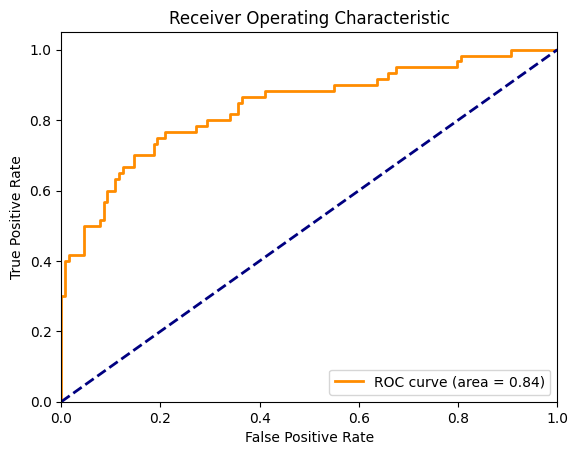

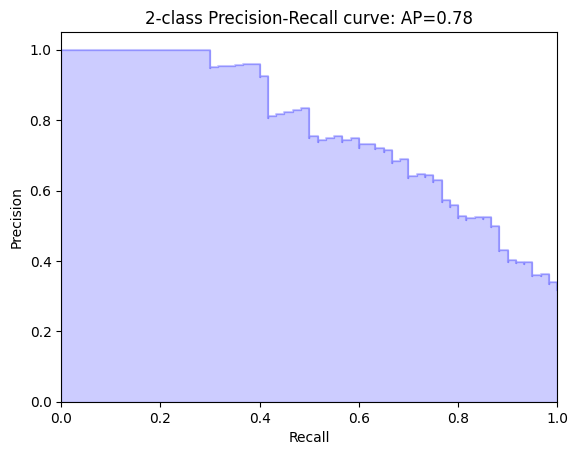

Confusion matrix, without normalization
[[110  19]
 [ 19  41]]


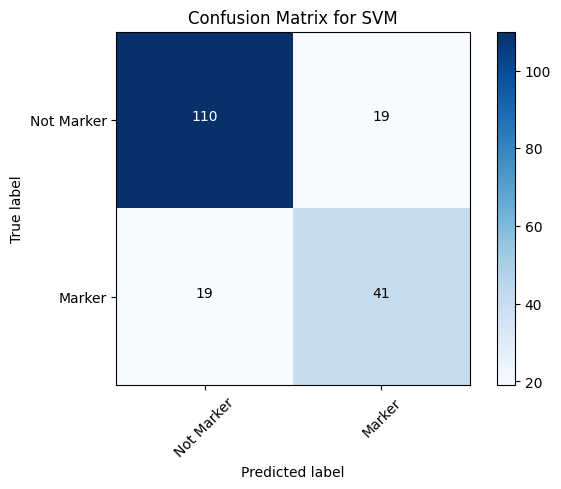

In [ ]:
# SVM Model Evaluation with Cross-Validation
def evaluate_and_plot_svm(feature_subset):
    X_subset = X[feature_subset]
    model = SVC(kernel='linear', probability=True, random_state=42)

    # Cross-validated predictions with probabilities
    y_proba = cross_val_predict(model, X_subset, y, cv=kfold, method="predict_proba")

    # Positive class is the second column
    plot_roc_curve(y, y_proba[:, 1])
    plot_precision_recall_curve(y, y_proba[:, 1])

evaluate_and_plot_svm(test_features)

# CM for SVM
y_pred_svm = cross_val_predict(SVC(kernel='linear', probability=True, random_state=42), X, y, cv=kfold, method="predict")
cm_svm = confusion_matrix(y, y_pred_svm)
plot_confusion_matrix(y, y_pred_svm, classes=['Not Marker', 'Marker'], title='Confusion Matrix for SVM')

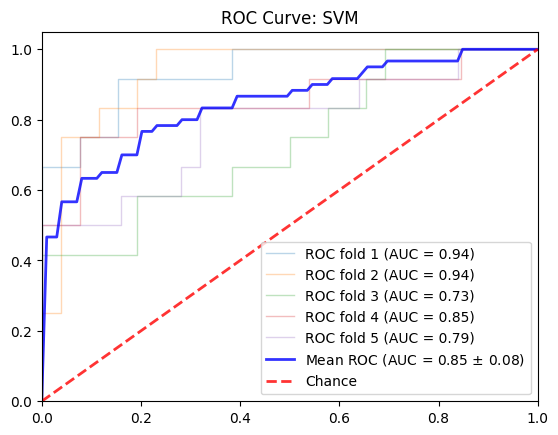

In [ ]:
# Plots on CV results:

# Using the previously defined X (features) and y (labels)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_model = SVC(kernel='linear', probability=True, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(kfold.split(X, y)):
    svm_model.fit(X.iloc[train], y.iloc[train])
    y_prob = svm_model.predict_proba(X.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y.iloc[test], y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
        lw=2, alpha=0.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05],
       title="ROC Curve: SVM")
ax.legend(loc="lower right")
plt.show()

2. Random Forest

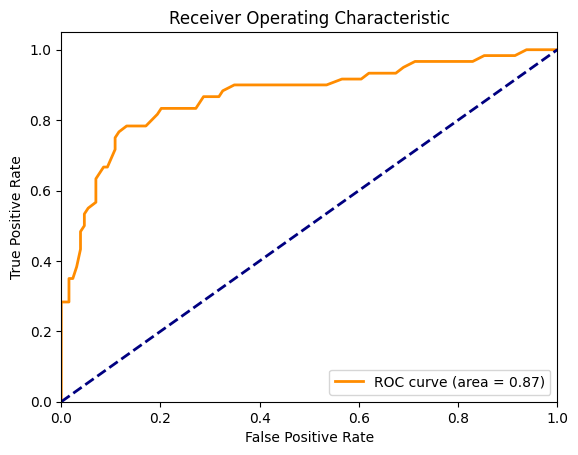

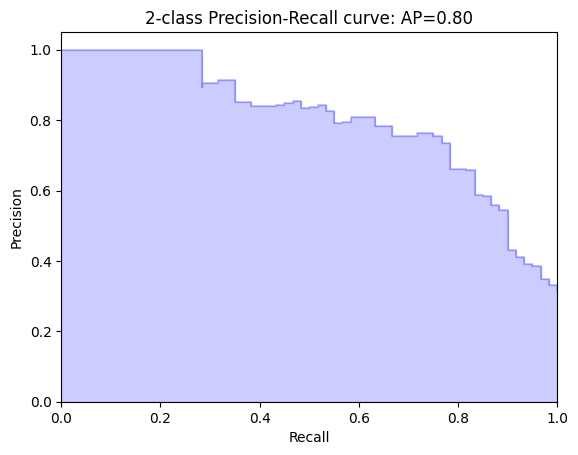

Confusion matrix, without normalization
[[122   7]
 [ 27  33]]


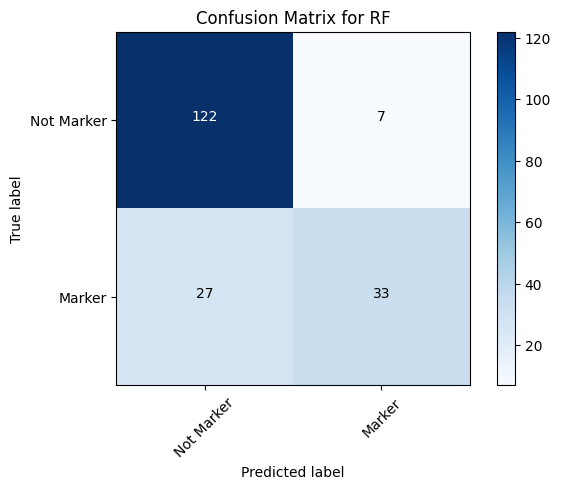

In [ ]:
# Random Forest Model Evaluation with Cross-Validation
def evaluate_and_plot_rf(feature_subset):
    X_subset = X[feature_subset]
    model = RandomForestClassifier(random_state=42)

    # Cross-validated predictions with probabilities
    y_proba = cross_val_predict(model, X_subset, y, cv=kfold, method="predict_proba")

    plot_roc_curve(y, y_proba[:, 1])
    plot_precision_recall_curve(y, y_proba[:, 1])

evaluate_and_plot_rf(test_features)

# CM for Random Forest
y_pred_rf = cross_val_predict(RandomForestClassifier(random_state=42), X, y, cv=kfold)
cm_rf = confusion_matrix(y, y_pred_rf)
plot_confusion_matrix(y, y_pred_rf, classes=['Not Marker', 'Marker'], title='Confusion Matrix for RF')

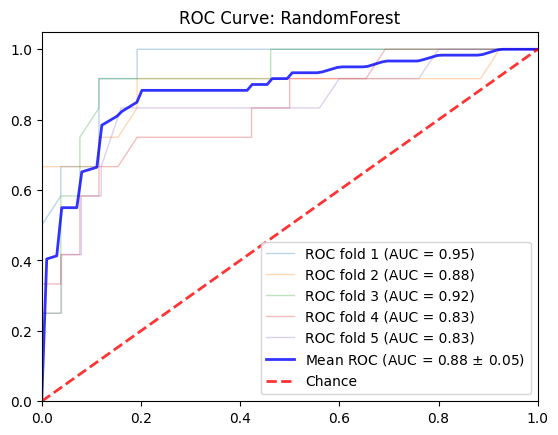

In [ ]:
# Plots on CV results:

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(kfold.split(X, y)):
    rf_model.fit(X.iloc[train], y.iloc[train])
    y_prob = rf_model.predict_proba(X.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y.iloc[test], y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
        lw=2, alpha=0.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05],
       title="ROC Curve: RandomForest")
ax.legend(loc="lower right")
plt.show()

3. Logistic Regression

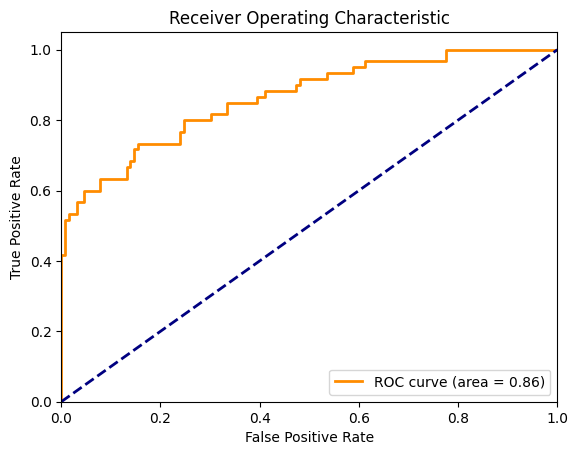

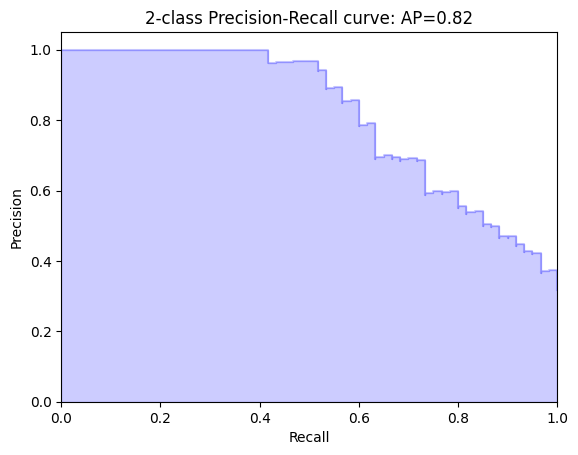

Confusion matrix, without normalization
[[112  17]
 [ 21  39]]


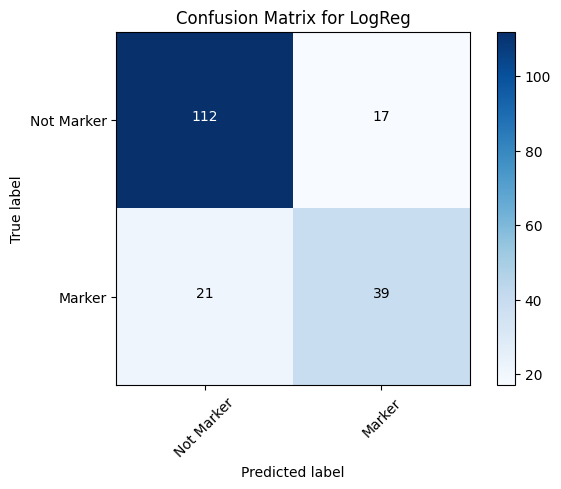

In [ ]:
# Logistic Regression Model Evaluation with Cross-Validation
def evaluate_and_plot_lr(feature_subset):
    X_subset = X[feature_subset]
    model = LogisticRegression(max_iter=1000, random_state=42)

    # Cross-validated predictions with probabilities
    y_proba = cross_val_predict(model, X_subset, y, cv=kfold, method="predict_proba")

    plot_roc_curve(y, y_proba[:, 1])
    plot_precision_recall_curve(y, y_proba[:, 1])

evaluate_and_plot_lr(test_features)

# CM for Logistic Regression
y_pred_lr = cross_val_predict(LogisticRegression(max_iter=1000), X, y, cv=kfold)
cm_lr = confusion_matrix(y, y_pred_lr)
plot_confusion_matrix(y, y_pred_lr, classes=['Not Marker', 'Marker'], title='Confusion Matrix for LogReg')

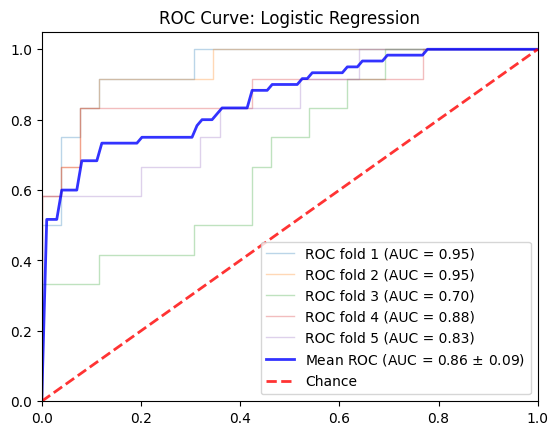

In [ ]:
# Plots on CV results:

logreg_model = LogisticRegression(max_iter=1000, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(kfold.split(X, y)):
    logreg_model.fit(X.iloc[train], y.iloc[train])
    y_prob = logreg_model.predict_proba(X.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y.iloc[test], y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
        lw=2, alpha=0.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05],
       title="ROC Curve: Logistic Regression")
ax.legend(loc="lower right")
plt.show()


4. Dense Layers

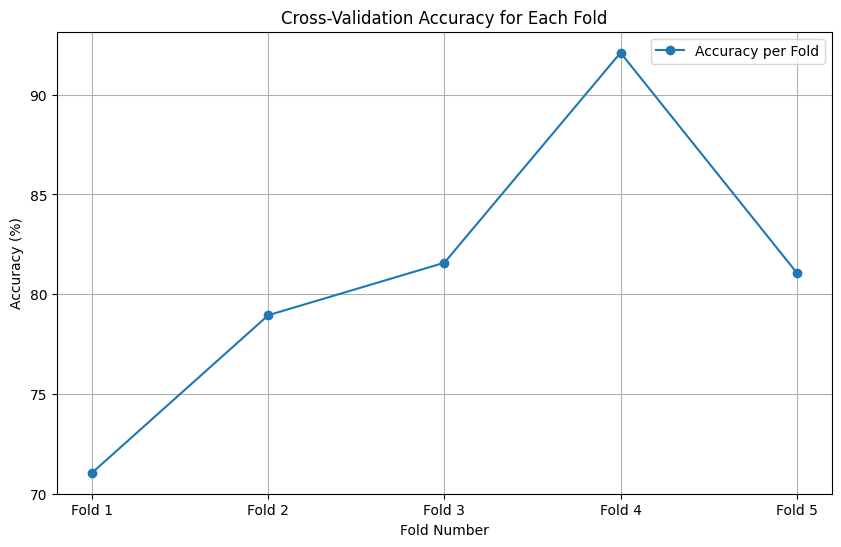

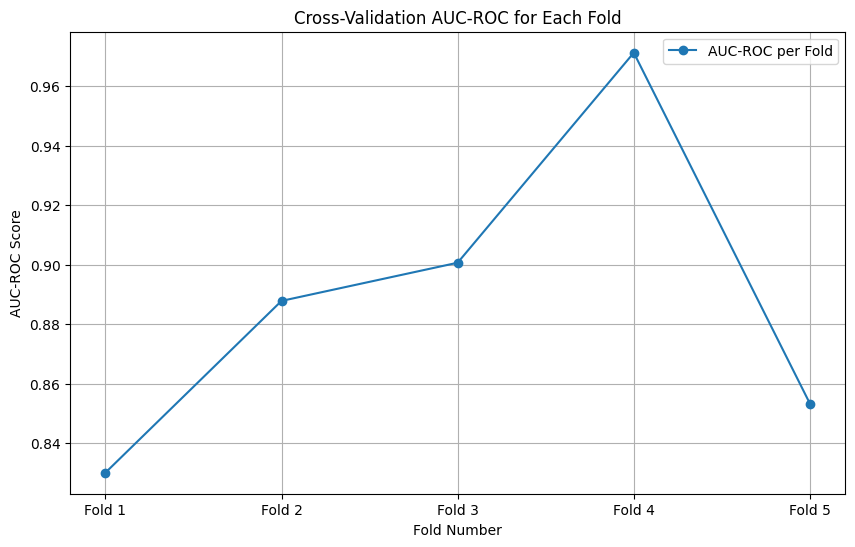

In [ ]:
# Plotting Cross-Validation Accuracies
plt.figure(figsize=(10, 6))
plt.plot(acc_per_fold, label='Accuracy per Fold', marker='o', linestyle='-')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy (%)')
plt.title('Cross-Validation Accuracy for Each Fold')
plt.xticks(ticks=range(len(acc_per_fold)), labels=[f'Fold {i+1}' for i in range(len(acc_per_fold))])
plt.legend()
plt.grid(True)
plt.show()


# Plotting Cross-Validation AUC-ROC Scores
plt.figure(figsize=(10, 6))
plt.plot(auc_roc_per_fold, label='AUC-ROC per Fold', marker='o', linestyle='-')
plt.xlabel('Fold Number')
plt.ylabel('AUC-ROC Score')
plt.title('Cross-Validation AUC-ROC for Each Fold')
plt.xticks(ticks=range(len(auc_roc_per_fold)), labels=[f'Fold {i+1}' for i in range(len(auc_roc_per_fold))])
plt.legend()
plt.grid(True)
plt.show()


# Qualitative Error Analysis:

CV split and Logistic Regression:

In [ ]:
# 1. Collect Predictions and True Labels for Each Fold

# Placeholder for fold results
fold_results = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)  # Example model

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # For ROC curve

    # Store results
    fold_results.append({
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    })

In [ ]:
# 2. Analyze Errors per Fold

for i, result in enumerate(fold_results, 1):
    errors = result['y_true'] != result['y_pred']
    print(f"Fold {i} Errors:")
    print(errors.value_counts())
    print()

Fold 1 Errors:
False    32
True      6
Name: Marker, dtype: int64

Fold 2 Errors:
False    31
True      7
Name: Marker, dtype: int64

Fold 3 Errors:
False    32
True      6
Name: Marker, dtype: int64

Fold 4 Errors:
False    34
True      4
Name: Marker, dtype: int64

Fold 5 Errors:
False    29
True      8
Name: Marker, dtype: int64



In [ ]:
# 3. Identifying false predictions:

# Placeholder for detailed fold results including incorrect predictions
detailed_fold_results = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Determine incorrect predictions
    incorrect_indices = np.where(y_pred != y_test)[0]
    incorrect_predictions = {
        'indices': test_index[incorrect_indices],
        'y_true': y_test.iloc[incorrect_indices].values,
        'y_pred': y_pred[incorrect_indices]
    }

    # Store detailed results
    detailed_fold_results.append({
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'incorrect_predictions': incorrect_predictions
    })

# Iterate through each fold's results in detailed_fold_results
for i, fold_result in enumerate(detailed_fold_results, start=1):
    incorrect_preds = fold_result['incorrect_predictions']
    print(f"Incorrect Predictions in Fold {i}:")
    print("Index\tTrue\tPredicted")

    # Check if there are incorrect predictions
    if len(incorrect_preds['indices']) > 0:
        for idx, true, pred in zip(incorrect_preds['indices'], incorrect_preds['y_true'], incorrect_preds['y_pred']):
            print(f"{idx}\t{true}\t{pred}")
    else:
        print("No incorrect predictions for this fold.")

    print()  # newline for better readability between folds

Incorrect Predictions in Fold 1:
Index	True	Predicted
31	0	1
32	0	1
47	1	0
74	0	1
94	0	1
161	1	0

Incorrect Predictions in Fold 2:
Index	True	Predicted
4	1	0
43	0	1
91	0	1
114	1	0
127	0	1
174	1	0
188	1	0

Incorrect Predictions in Fold 3:
Index	True	Predicted
3	1	0
54	0	1
78	1	0
97	1	0
129	0	1
167	1	0

Incorrect Predictions in Fold 4:
Index	True	Predicted
56	0	1
133	1	0
156	1	0
183	1	0

Incorrect Predictions in Fold 5:
Index	True	Predicted
27	1	0
28	1	0
38	1	0
108	1	0
140	1	0
152	0	1
159	1	0
175	0	1



<ipython-input-30-abd2f4a7ce58>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test_fold.loc[correct_fold, feature], label='Correct', hist=False, rug=True)
<ipython-input-30-abd2f4a7ce58>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test_fold.loc[incorrect_fold, fea

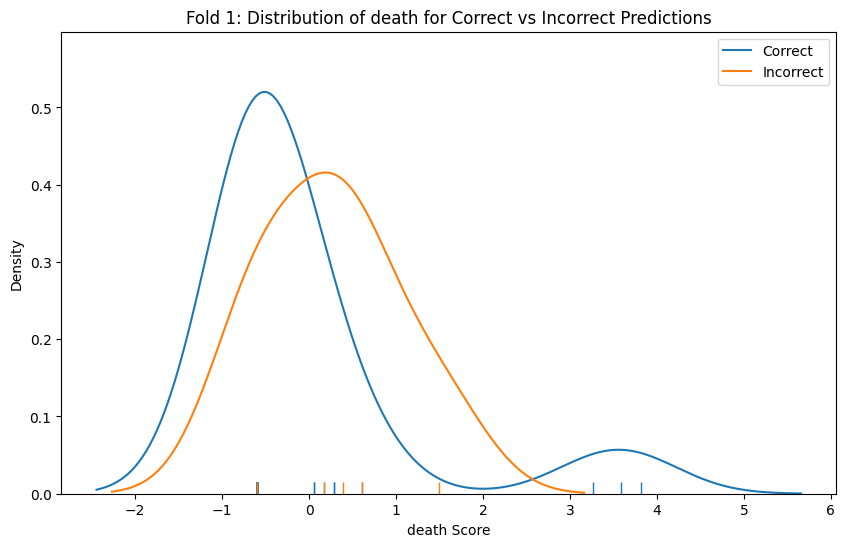

<ipython-input-30-abd2f4a7ce58>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test_fold.loc[correct_fold, feature], label='Correct', hist=False, rug=True)
<ipython-input-30-abd2f4a7ce58>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test_fold.loc[incorrect_fold, fea

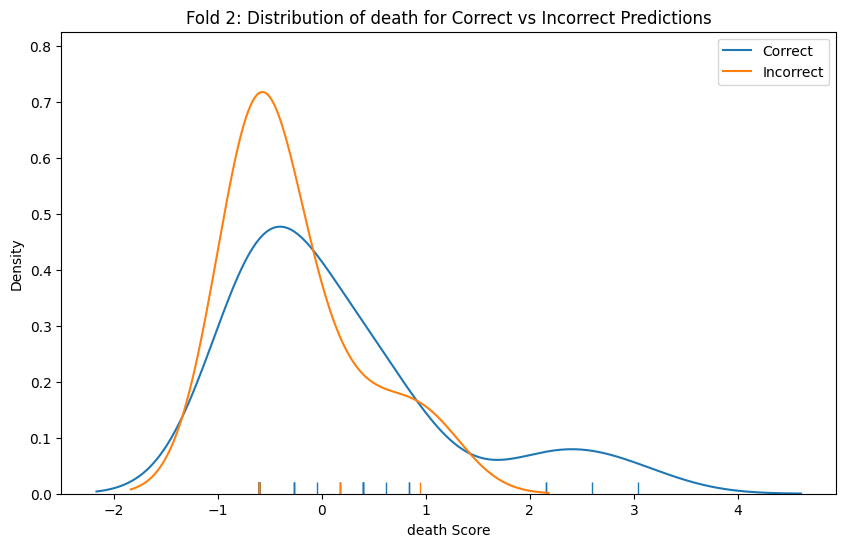

<ipython-input-30-abd2f4a7ce58>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test_fold.loc[correct_fold, feature], label='Correct', hist=False, rug=True)
<ipython-input-30-abd2f4a7ce58>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test_fold.loc[incorrect_fold, fea

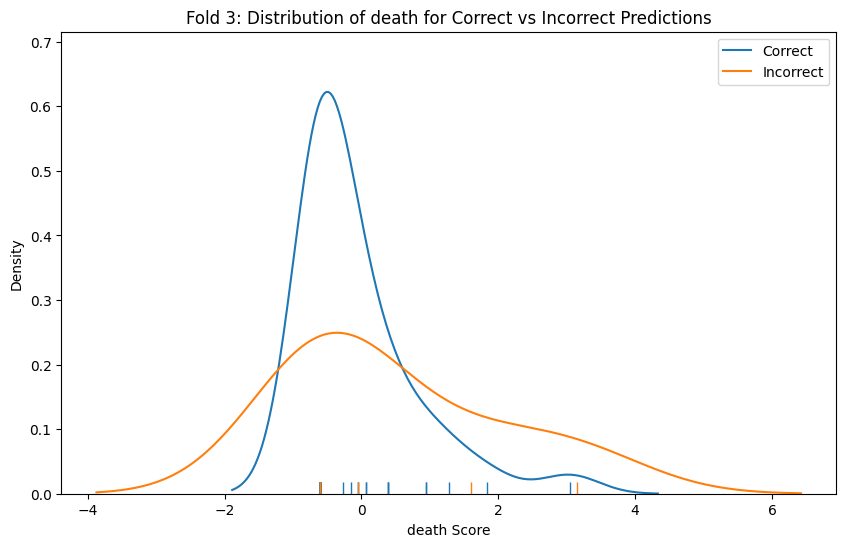

<ipython-input-30-abd2f4a7ce58>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test_fold.loc[correct_fold, feature], label='Correct', hist=False, rug=True)
<ipython-input-30-abd2f4a7ce58>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test_fold.loc[incorrect_fold, fea

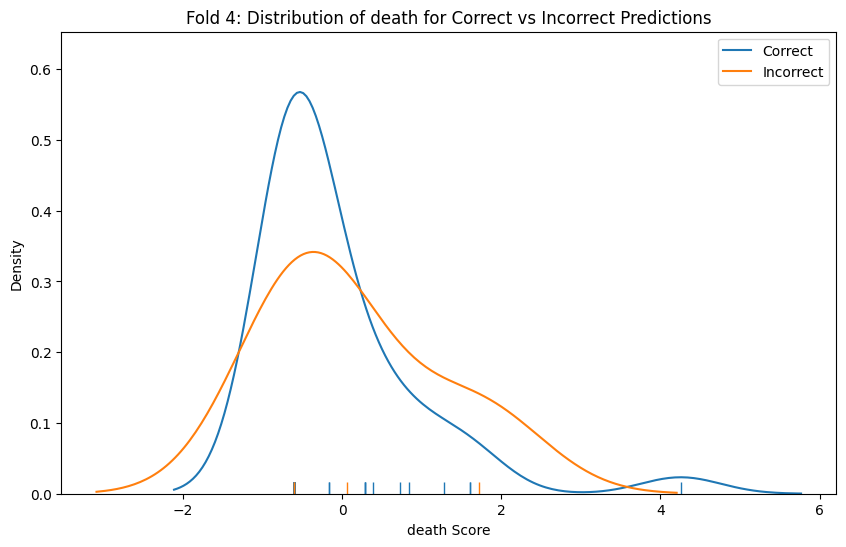

<ipython-input-30-abd2f4a7ce58>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test_fold.loc[correct_fold, feature], label='Correct', hist=False, rug=True)
<ipython-input-30-abd2f4a7ce58>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test_fold.loc[incorrect_fold, fea

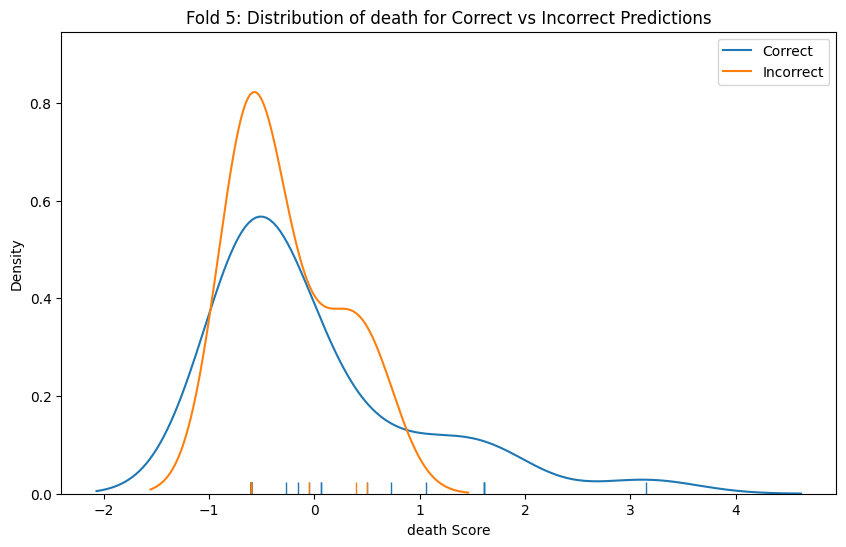

In [ ]:
# 4. visualization

# Assuming 'death' is the feature to analyze
feature = 'death'

# Adjust visualization inside the loop for each fold's results
for i, result in enumerate(fold_results, 1):
    y_true_fold = result['y_true']
    y_pred_fold = result['y_pred']
    X_test_fold = X.iloc[result['y_true'].index]  # Adjust to get test set features based on y_true's index for the fold

    # Compute correct and incorrect prediction masks for the current fold
    correct_fold = y_pred_fold == y_true_fold
    incorrect_fold = ~correct_fold

    # Plot distribution for 'death' feature for Correct vs Incorrect Predictions
    plt.figure(figsize=(10, 6))
    sns.distplot(X_test_fold.loc[correct_fold, feature], label='Correct', hist=False, rug=True)
    sns.distplot(X_test_fold.loc[incorrect_fold, feature], label='Incorrect', hist=False, rug=True)
    plt.legend()
    plt.title(f'Fold {i}: Distribution of {feature} for Correct vs Incorrect Predictions')
    plt.xlabel(f'{feature} Score')
    plt.ylabel('Density')
    plt.show()

# Creating 2 dataframes for experimentation (for Multimodal approach):

In [ ]:
# pre-process final text features set

text_df = pd.read_csv('/content/drive/My Drive/DAIC-Woz/COMPLETE_text_feature_set_labeled.csv')

# Rename 'Filename' to 'interview_id' and extract the numeric part
text_df['interview_id'] = text_df['Filename'].str.extract('(\d+)').astype(int)

# Drop the 'Filename' column
text_df.drop('Filename', axis=1, inplace=True)

# Reordering columns
column_order = ['interview_id'] + [col for col in text_df.columns if col != 'interview_id']
text_df = text_df[column_order]

# Exclude interview 300, since it has also been excluded from the audio model (too much noise)
text_df = text_df[text_df['interview_id'] != 300]



# top 20 text features from best feature selector:
feat_20 = [
    'posemo', 'anx', 'sad', 'death', 'glove_dim_9', 'glove_dim_10', 'glove_dim_33', 'glove_dim_36', 'glove_dim_46', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'glove_dim_83',
    'glove_dim_87', 'glove_dim_89', 'VBG_Count', 'JJR_Count', 'RB_Count', 'RBS_Count', 'WP_Count'
]

text_df_20 = text_df[['interview_id', 'Marker'] + feat_20]

# Save new dataframe
text_df_20.to_csv('/content/drive/My Drive/DAIC-Woz/TEXT-20-for-concat.csv', index=False)




# top 15 text features (same selector):
feat_15 = [
    'posemo', 'anx', 'sad', 'death', 'glove_dim_9', 'glove_dim_33', 'glove_dim_46', 'glove_dim_63', 'glove_dim_64', 'glove_dim_71', 'glove_dim_87', 'VBG_Count', 'JJR_Count',
    'RB_Count', 'WP_Count'
]

text_df_15 = text_df[['interview_id', 'Marker'] + feat_15]

# Save new dataframe
text_df_15.to_csv('/content/drive/My Drive/DAIC-Woz/TEXT-15-for-concat.csv', index=False)